# Projet Final INFMDI721 Kit Data Science

**par Clément LIAIGRE**

Ce projet s'appuie sur des données provenant du site web du Vendée Globe et s'articule en plusieurs étapes :
1. Récupération et nettoyage des données
    1. Récupération des fichiers Excel des classements du Vendée Globe
    2. Création d'un DataFrame de l'évolution du classement du Vendée Globe à partir des fichiers Excel et nettoyage des données
    3. Récupération des données techniques des voiliers et nettoyage des données
2. Rapprochement des données des voiliers avec celles des classements au sein d'un seul DataFrame
3. Analyse descriptive et visualisation des données du DataFrame
    1. Analyse de la relation entre les variables VMG et Rang
    2. Analyse de l'impact de la présence d'un foil sur la VMG et le rang du skipper
    3. Analyse de l'impact des autres variables (largeur, déplacement (poids), hauteur de mât, surface de voiles au près et surface de voiles au portant) sur la VMG
    4. Représentation de séries temporelles (évolution du rang, évolution de la VMG, trajet parcouru par les skippers)
    5. Cartes avec les routes des voiliers
    6. Analyse des relations entre les variables
4. Application d'algorithmes de Machine Learning afin de prédire à quel segment d'un rang appartient un skipper 

In [1]:
#importation des librairies nécessaires pour le projet
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from glob import glob
import os
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tempfile
from zipfile import ZipFile
import shutil
import os
from fnmatch import fnmatch

# 1. Récupération et nettoyage des données

## A. Récupération des fichiers Excel des classements du Vendée Globe

**ATTENTION : Les fonctions ont déjà été exécutées pour récupérer les fichiers Excel.**

In [2]:
url_class = 'https://www.vendeeglobe.org/fr/classement/'
text_file = 'url_download.txt'
folder = './VendeeGlobeRanking/'

In [3]:
"""
def url_name(url):
    url_origin = re.search('(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))', url).group(0)
    template = re.compile('\d+_(04|08|11|14|17|21)(0000)')

    r_url = requests.get(url)
    content_url = r_url.content.decode('utf-8')
    soup_url = BeautifulSoup(content_url, "html.parser")

    output = open('url_download.txt', 'a')

    for option_tag in soup_url.findAll('option'):
        if template.match(option_tag.attrs['value']):
            r_new_url = requests.get(url + option_tag.attrs['value'])
            content_new_url = r_new_url.content.decode('utf-8')
            soup_new_url = BeautifulSoup(content_new_url, "html.parser")
            a_tag = soup_new_url.find('a', {'class': "rankings__download"})
            if a_tag == None:
                continue
            else:
                output.write(url_origin + a_tag['href'] + '\n')
                
    output.close()
"""

'\ndef url_name(url):\n    url_origin = re.search(\'(http|ftp|https):\\/\\/([\\w_-]+(?:(?:\\.[\\w_-]+)+))\', url).group(0)\n    template = re.compile(\'\\d+_(04|08|11|14|17|21)(0000)\')\n\n    r_url = requests.get(url)\n    content_url = r_url.content.decode(\'utf-8\')\n    soup_url = BeautifulSoup(content_url, "html.parser")\n\n    output = open(\'url_download.txt\', \'a\')\n\n    for option_tag in soup_url.findAll(\'option\'):\n        if template.match(option_tag.attrs[\'value\']):\n            r_new_url = requests.get(url + option_tag.attrs[\'value\'])\n            content_new_url = r_new_url.content.decode(\'utf-8\')\n            soup_new_url = BeautifulSoup(content_new_url, "html.parser")\n            a_tag = soup_new_url.find(\'a\', {\'class\': "rankings__download"})\n            if a_tag == None:\n                continue\n            else:\n                output.write(url_origin + a_tag[\'href\'] + \'\n\')\n                \n    output.close()\n'

In [4]:
"""
url_name(url_class)
"""

'\nurl_name(url_class)\n'

In [5]:
"""def change_in_zip(file_name, name_filter, change):
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)           
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)
    
def download_xlsx_files(text_file, folder):
    input = open(text_file, 'r')
    lines = input.readlines()

    for line in lines:
        filename = re.search('(vendee)\w+(.xlsx)', line).group(0)
        resp = requests.get(line)
        output = open(folder + filename, 'wb')
        output.write(resp.content)
        output.close()
        change_in_zip(folder + filename, 
              name_filter='xl/styles.xml',
              change=lambda d: re.sub(b'xxid="\d*"', b"", d))

    input.close()
"""

'def change_in_zip(file_name, name_filter, change):\n    tempdir = tempfile.mkdtemp()\n    try:\n        tempname = os.path.join(tempdir, \'new.zip\')\n        with ZipFile(file_name, \'r\') as r, ZipFile(tempname, \'w\') as w:\n            for item in r.infolist():\n                data = r.read(item.filename)           \n                data = change(data)\n                w.writestr(item, data)\n        shutil.move(tempname, file_name)\n    finally:\n        shutil.rmtree(tempdir)\n    \ndef download_xlsx_files(text_file, folder):\n    input = open(text_file, \'r\')\n    lines = input.readlines()\n\n    for line in lines:\n        filename = re.search(\'(vendee)\\w+(.xlsx)\', line).group(0)\n        resp = requests.get(line)\n        output = open(folder + filename, \'wb\')\n        output.write(resp.content)\n        output.close()\n        change_in_zip(folder + filename, \n              name_filter=\'xl/styles.xml\',\n              change=lambda d: re.sub(b\'xxid="\\d*"\', b"", d

In [6]:
"""
download_xlsx_files(text_file, folder)
"""

'\ndownload_xlsx_files(text_file, folder)\n'

## B. Création d'un DataFrame de l'évolution du classement du Vendée Globe à partir des fichiers Excel et nettoyage des données

In [7]:
path = "**/VendeeGlobeRanking/*.xlsx"
url_tech = 'https://www.vendeeglobe.org/fr/glossaire'

In [8]:
def conversion_float(string):
    """
    Input : chaîne de caractère
    Output : chiffres de la chaîne de caractère convertis en float
    """
    value = re.search('[+-]?([0-9]*[.])?[0-9]+', string).group(0)
    return float(value)

In [9]:
def dm2dec(degmin):
    """
    Input : coordonnée en deg et min
    Output : coordonnée en décimal
    """
    directions = {'N':1, 'S':-1, 'E': 1, 'W':-1}
    degres = float(re.search("(.*?)(?=°)", degmin).group(0))
    minutes = float(re.search("(?<=°)(.*?)(?=')", degmin).group(0))
    card = re.search("\w[^']*$", degmin).group(0)
    dec = (degres + minutes / 60) * directions[card]
    return dec

In [10]:
def cleaning_rank_df(path):
    """
    Input : chemin de stockage des fichiers xlsx
    Output : DataFrame du contenu des fichiers xlsx post nettoyage
    """
    xlsx_paths = glob(path, recursive=True)
    
    df = pd.DataFrame()
    
    #lecture des fichiers excel, création d'un dataframe et ajout de la colonne 'Date'
    for xlsx_path in sorted(xlsx_paths):
        df_xlsx_path = pd.read_excel(xlsx_path, 
                            names=['', 'Rang', 'Nat / Voile', 'Skipper / Bateau', 'Heure FR', 'Latitude', 'Longitude', 
                                   'Cap depuis 30 min (°)', 'Vitesse depuis 30 min (kts)', 'VMG depuis 30 min (kts)', 'Distance depuis 30 min (nm)', 
                                   'Cap depuis dernier classement (°)', 'Vitesse depuis dernier classement (kts)', 'VMG depuis dernier classement (kts)', 'Distance depuis dernier classement (nm)', 
                                   'Cap depuis 24h (°)', 'Vitesse depuis 24h (kts)', 'VMG depuis 24h (kts)', 'Distance depuis 24h (nm)', 
                                   'DTF (nm)', 'DTL (nm)'], 
                            skiprows=[0, 1, 2, 3])
        df_xlsx_path.insert(4, 'Date', re.search('\d+_\d+', os.path.basename(xlsx_path)).group(0).replace('_',' '))
        del df_xlsx_path['']
        df = pd.concat([df, df_xlsx_path])
    
    #reset de l'index
    df = df.reset_index()
    del df['index']
    
    #conversion de la colonne 'Date' en datetime
    df.loc[:, 'Date'] = pd.to_datetime(df.loc[:, 'Date']) 
     
    #suppression des lignes inutiles (arrivées des participants / lignes non pertinentes)
    df = df.dropna(subset=['Skipper / Bateau'])
    row_rank_rmv = ['NL', 'Rang']#, 'ARV']
    df = df[~df['Rang'].str.contains('|'.join(row_rank_rmv))]
    
    #création des colonnes 'Nation' et 'Voile' et suppression de la colonne 'Nat / Voile'
    df.insert(2, 'Nation', df['Nat / Voile'].apply(lambda x : re.search('\w+', x).group(0)))
    df.insert(3, '# Voile', df['Nat / Voile'].apply(lambda x : re.search('\d+', x).group(0)))
    del df['Nat / Voile']
    
    #création des colonnes 'Skipper' et 'Bateau' et suppression de la colonne 'Skipper / Bateau'
    df.insert(4, 'Skipper', df['Skipper / Bateau'].apply(lambda x : re.search('.+\n', x).group(0).replace('\n', '')))
    df.insert(5, 'Bateau', df['Skipper / Bateau'].apply(lambda x : re.search('\n.+', x).group(0).replace('\n', '')))
    del df['Skipper / Bateau']
    
    #suppression des doublons des participants ayant abandonnés en conservant seulement la première ligne
    df = df.loc[~((df['Rang'] == 'RET') & (df.duplicated(subset=['Rang', 'Skipper'])))]
    df = df.loc[~((df['Rang'].str.contains('ARV')) & (df.duplicated(subset=['Rang'], keep = 'last')))]
    df.loc[df['Rang'].str.contains('ARV'), df.columns[5:]] = np.NaN
    #imputer les NaN des lignes restantes des abandons des Skippers par leurs dernières valeurs en course
    for skp in df['Skipper'].unique():
        df.loc[(df['Skipper'] == skp)] = df.loc[(df['Skipper'] == skp)].fillna(method='ffill')
        df.loc[(df['Skipper'] == skp), 'Date'] = df.loc[(df['Skipper'] == skp), 'Date']
    
    #suppression de la notation ARV sur les rangs finaux
    df.loc[df['Rang'] != 'RET', 'Rang'] = df.loc[df['Rang'] != 'RET', 'Rang'].apply(lambda x : re.search('\d+', x).group(0))
    
    #conservation seulement de l'heure FR en format %H:%M dans la colonne 'Heure FR' 
    df.loc[:, ['Heure FR']] = df.loc[:, ['Heure FR']].applymap(lambda x: re.search('\d+(:)\d+', x).group(0))
    
    #conversion des colonnes Latitude et Longitude en format décimal
    df.loc[:, 'Latitude'] = df.loc[:, 'Latitude'].apply(lambda x : dm2dec(x))
    df.loc[:, 'Longitude'] = df.loc[:, 'Longitude'].apply(lambda x : dm2dec(x))
    
    #conservation de la métrique sans l'unité pour les colonnes Cap, Vitesse, VMG et Distance, DTF et DTL
    df.loc[:, df.columns[9:]] = df.loc[:, df.columns[9:]].applymap(lambda x : conversion_float(x))
    
    #correction des erreurs dans la numérotation des voiles dans les fichiers Excel
    df.loc[df['# Voile'] == '01', '# Voile'] = '001'
    df.loc[df['# Voile'] == '02', '# Voile'] = '2'
    df.loc[df['# Voile'] == '7', '# Voile'] = '07'
    df.loc[df['# Voile'] == '8', '# Voile'] = '08'
    df.loc[df['# Voile'] == '10', '# Voile'] = '16'
    df.loc[df['# Voile'] == '777', '# Voile'] = '77'
    
    #reset de l'index
    df = df.reset_index()
    del df['index']
    
    for skp in df['Skipper'].unique():
        df.iloc[df.loc[df['Skipper'] == skp].index[-1], 5] = df.iloc[df.loc[df['Skipper'] == skp].index[-1], 5] + pd.Timedelta(24, unit='h') 
    
    return df

In [11]:
df_class = cleaning_rank_df(path)
df_class.head(10)

Rang Nation # Voile           Skipper                              Bateau  \
0    1    FRA      08     Jérémie Beyou                              Charal   
1    2    FRA      79     Charlie Dalin                              APIVIA   
2    3    FRA      59     Thomas Ruyant                           LinkedOut   
3    4    GBR      99      Alex Thomson                           Hugo Boss   
4    5    MON      16    Boris Herrmann  Seaexplorer - Yacht Club De Monaco   
5    6    FRA       6  Nicolas Troussel                     CORUM L'Épargne   
6    7     FR       2      Armel Tripon              L'Occitane en Provence   
7    8    FRA       4   Sébastien Simon                        ARKEA PAPREC   
8    9    FRA      17  Yannick Bestaven                       Maître Coq IV   
9   10    FRA     109   Samantha Davies                 Initiatives - Coeur   

                 Date Heure FR   Latitude  Longitude  Cap depuis 30 min (°)  \
0 2020-11-08 17:00:00    18:30  46.329167  -3.450333                  268.0   
1 2020-11-08 17:00:00    18:30  46.265333  -3.366500                  266.0   
2 2020-11-08 17:00:00    18:30  46.317667  -3.402000                  265.0   
3 2020-11-08 17:00:00    18:30  46.255500  -3.315667                  265.0   
4 2020-11-08 17:00:00    18:30  46.284000  -3.311833                  269.0   
5 2020-11-08 17:00:00    18:30  46.374333  -3.375000                  266.0   
6 2020-11-08 17:00:00    18:30  46.354833  -3.332333                  270.0   
7 2020-11-08 17:00:00    18:30  46.274500  -3.228167                  269.0   
8 2020-11-08 17:00:00    18:30  46.242667  -3.176833                  268.0   
9 2020-11-08 17:00:00    18:30  46.349000  -3.275833                  271.0   

   ...  Cap depuis dernier classement (°)  \
0  ...                              268.0   
1  ...                              267.0   
2  ...                              269.0   
3  ...                              264.0   
4  ...                              268.0   
5  ...                              271.0   
6  ...                              271.0   
7  ...                              267.0   
8  ...                              264.0   
9  ...                              270.0   

   Vitesse depuis dernier classement (kts)  \
0                                     23.7   
1                                     23.3   
2                                     23.9   
3                                     21.9   
4                                     22.6   
5                                     22.9   
6                                     23.6   
7                                     20.9   
8                                     21.6   
9                                     21.6   

   VMG depuis dernier classement (kts)  \
0                                 20.6   
1                                 20.6   
2                                 20.6   
3                                 19.9   
4                                 19.9   
5                                 19.4   
6                                 20.0   
7                                 18.5   
8                                 19.6   
9                                 18.4   

   Distance depuis dernier classement (nm)  Cap depuis 24h (°)  \
0                                     35.6               261.0   
1                                     35.0               257.0   
2                                     35.8               260.0   
3                                     32.9               256.0   
4                                     34.0               258.0   
5                                     34.3               263.0   
6                                     35.4               262.0   
7                                     31.4               257.0   
8                                     32.4               254.0   
9                                     32.4               261.0   

   Vitesse depuis 24h (kts)  VMG depuis 24h (kts)  Distance depuis 24

In [12]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Data columns (total 23 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Rang                                     15208 non-null  object        
 1   Nation                                   15208 non-null  object        
 2   # Voile                                  15208 non-null  object        
 3   Skipper                                  15208 non-null  object        
 4   Bateau                                   15208 non-null  object        
 5   Date                                     15208 non-null  datetime64[ns]
 6   Heure FR                                 15208 non-null  object        
 7   Latitude                                 15208 non-null  float64       
 8   Longitude                                15208 non-null  float64       
 9   Cap depuis 30 min (°)                  

In [13]:
df_class.isna().sum()

Rang                                       0
Nation                                     0
# Voile                                    0
Skipper                                    0
Bateau                                     0
Date                                       0
Heure FR                                   0
Latitude                                   0
Longitude                                  0
Cap depuis 30 min (°)                      0
Vitesse depuis 30 min (kts)                0
VMG depuis 30 min (kts)                    0
Distance depuis 30 min (nm)                0
Cap depuis dernier classement (°)          0
Vitesse depuis dernier classement (kts)    0
VMG depuis dernier classement (kts)        0
Distance depuis dernier classement (nm)    0
Cap depuis 24h (°)                         0
Vitesse depuis 24h (kts)                   0
VMG depuis 24h (kts)                       0
Distance depuis 24h (nm)                   0
DTF (nm)                                   0
DTL (nm)  

## C. Récupération des données techniques des voiliers

In [14]:
def features_boat_df(url):
    """
    Input : url contenant les informations techniques des voiliers
    Output : DataFrame du contenu de l'url post nettoyage
    """
    r = requests.get(url)
    content = r.content.decode('utf-8')
    soup = BeautifulSoup(content, "html.parser")
    
    rows = []

    for div_tag in soup.findAll('div', attrs={'class': "boats-list__popup-infos"}):
        row = {}
        h3_tag = div_tag.find('h3')
        row['Bateau'] = h3_tag.text
        li_tag = div_tag.select('li')
        for li in li_tag:
            row[re.search('([^:]+)\w', li.text).group(0)] = re.search('\w[^:]*$', li.text).group(0)
        rows.append(row)
        
    df = pd.DataFrame(rows)
    
    df = df.rename(columns = {'Longueur' : 'Longueur (m)', 'Largeur' : 'Largeur (m)', 
                              "Tirant d'eau" : "Tirant d'eau (m)", 'Déplacement (poids' : 'Déplacement (t)',
                             "Hauteur mât" : "Hauteur mât (m)", 
                              'Surface de voiles au près' : 'Surface de voiles au près (m2)',
                             'Surface de voiles au portant' : 'Surface de voiles au portant (m2)'})
    
    df = df.replace(['nc', 'NC'], np.NaN)
    
    #imputation du NaN dans la colonne 'Numéro de voile' du bateau 'LinkedOut'
    df.loc[df['Bateau'] == 'LinkedOut', 'Numéro de voile'] = 'FRA 59'
    #imputation des NaN dans la colonne 'Déplacement (t)' du bateau 'PRB' et 'LA FABRIQUE' à partir de la page Wikipédia du Vendée Globe : https://fr.wikipedia.org/wiki/Vendée_Globe_2020-2021#Caractéristiques_techniques_des_bateaux
    df.loc[df['Bateau'] == 'PRB', 'Déplacement (t)'] = '7,7 t'
    df.loc[df['Bateau'] == 'LA FABRIQUE', 'Déplacement (t)'] = '8 t'
    
    #conservation seulement du numéro de voile
    df.loc[:, 'Numéro de voile'] = df.loc[:, 'Numéro de voile'].apply(lambda x : re.search('\d+', x).group(0))
    
    #suppression des colonnes non exploitées
    del df['Anciens noms du bateau']
    del df['Voile quille']
    del df['Architecte']
    del df['Chantier']
    del df['Date de lancement']
    
    #conservation de la métrique sans l'unité pour les colonnes Longueur, Largeur, Tirant d'eau et Déplacement
    df.loc[:, df.columns[2:6]] = df.loc[:, df.columns[2:6]].apply(lambda x: x.str.replace(',', '.'))
    df.loc[:, df.columns[2:6]] = df.loc[:, df.columns[2:6]].applymap(lambda x : conversion_float(x))
    df[df.columns[2:6]] = df[df.columns[2:6]].astype(float)
    
    #imputation uniquement de 2 modalités pour la colonne 'Nombre de dérives' (2 et foils)
    df.loc[:, 'Nombre de dérives'] = df.loc[:, 'Nombre de dérives'].str.replace('foiler', 'foils')
    df.loc[:, 'Nombre de dérives'] = df.loc[:, 'Nombre de dérives'].str.replace('2 asymétriques', '2')
    df.insert(7, 'Foils', df['Nombre de dérives'].str.replace('2', 'no foils'))
    
    #conservation de la métrique sans l'unité pour les colonnes Hauteur mât, Surface de voiles au près et Surface de voiles au portant
    df.loc[:, df.columns[-3]] = df.loc[:, df.columns[-3]].apply(lambda x: x.replace(',', '.'))
    df.loc[:, df.columns[-3:]] = df.loc[:, df.columns[-3:]].applymap(lambda x : conversion_float(x))
    df[df.columns[-3:]] = df[df.columns[-3:]].astype(float)
    
    return df

In [15]:
df_tech = features_boat_df(url_tech)

In [16]:
df_tech.head(10)

Bateau Numéro de voile  Longueur (m)  \
0           NEWREST - ART & FENÊTRES              56         18.28   
1               PURE - Best Western®              49         18.28   
2                   TSE -  4MYPLANET              72         18.28   
3                      Maître CoQ IV              17         18.28   
4                             CHARAL              08         18.28   
5  LA MIE CÂLINE - ARTISANS ARTIPÔLE              14         18.28   
6                    BUREAU VALLEE 2              18         18.28   
7               ONE PLANET ONE OCEAN              33         18.28   
8                       GROUPE SÉTIN              71         18.28   
9                 BANQUE POPULAIRE X              30         18.28   

   Largeur (m)  Tirant d'eau (m)  Déplacement (t) Nombre de dérives     Foils  \
0         5.85               4.5              7.0             foils     foils   
1         5.80               4.5              9.0                 2  no foils   
2         5.54               4.5              9.0                 2  no foils   
3         5.80               4.5              8.0             foils     foils   
4         5.85               4.5              8.0             foils     foils   
5         5.65               4.5              7.9             foils     foils   
6         5.80               4.5              7.6             foils     foils   
7         5.30               4.5              8.9                 2  no foils   
8         5.80               4.5              9.0                 2  no foils   
9         5.70               4.5              7.7                 2  no foils   

   Hauteur mât (m)  Surface de voiles au près (m2)  \
0             29.0                           320.0   
1             28.0                           280.0   
2             29.0                           260.0   
3             29.0                           310.0   
4             29.0                           320.0   
5             29.0                           300.0   
6             28.0                           300.0   
7             26.0                           240.0   
8             28.5                           270.0   
9             29.0                           340.0   

   Surface de voiles au portant (m2)  
0                              570.0  
1                              560.0  
2                              580.0  
3                              550.0  
4                              600.0  
5                              610.0  
6                              600.0  
7                              470.0  
8                              560.0  
9                              570.0

In [17]:
df_tech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Bateau                             33 non-null     object 
 1   Numéro de voile                    33 non-null     object 
 2   Longueur (m)                       33 non-null     float64
 3   Largeur (m)                        33 non-null     float64
 4   Tirant d'eau (m)                   33 non-null     float64
 5   Déplacement (t)                    33 non-null     float64
 6   Nombre de dérives                  33 non-null     object 
 7   Foils                              33 non-null     object 
 8   Hauteur mât (m)                    33 non-null     float64
 9   Surface de voiles au près (m2)     33 non-null     float64
 10  Surface de voiles au portant (m2)  33 non-null     float64
dtypes: float64(7), object(4)
memory usage: 3.0+ KB


In [18]:
df_tech.isna().sum()

Bateau                               0
Numéro de voile                      0
Longueur (m)                         0
Largeur (m)                          0
Tirant d'eau (m)                     0
Déplacement (t)                      0
Nombre de dérives                    0
Foils                                0
Hauteur mât (m)                      0
Surface de voiles au près (m2)       0
Surface de voiles au portant (m2)    0
dtype: int64

# 2. Rapprochement des données des voiliers avec celles des classements au sein d'un seul DataFrame

In [19]:
df_cleaned = pd.merge(df_class, df_tech[df_tech.columns[1:]], 
                      left_on='# Voile', 
                      right_on='Numéro de voile', 
                      how='left')

In [20]:
df_cleaned.head(5)

Rang Nation # Voile         Skipper                              Bateau  \
0    1    FRA      08   Jérémie Beyou                              Charal   
1    2    FRA      79   Charlie Dalin                              APIVIA   
2    3    FRA      59   Thomas Ruyant                           LinkedOut   
3    4    GBR      99    Alex Thomson                           Hugo Boss   
4    5    MON      16  Boris Herrmann  Seaexplorer - Yacht Club De Monaco   

                 Date Heure FR   Latitude  Longitude  Cap depuis 30 min (°)  \
0 2020-11-08 17:00:00    18:30  46.329167  -3.450333                  268.0   
1 2020-11-08 17:00:00    18:30  46.265333  -3.366500                  266.0   
2 2020-11-08 17:00:00    18:30  46.317667  -3.402000                  265.0   
3 2020-11-08 17:00:00    18:30  46.255500  -3.315667                  265.0   
4 2020-11-08 17:00:00    18:30  46.284000  -3.311833                  269.0   

   ...  Numéro de voile  Longueur (m)  Largeur (m)  Tirant d'eau (m)  \
0  ...               08         18.28         5.85               4.5   
1  ...               79         18.28         5.85               4.5   
2  ...               59         18.28         5.85               4.5   
3  ...               99         18.28         5.40               4.5   
4  ...               16         18.28         5.70               4.5   

   Déplacement (t)  Nombre de dérives  Foils  Hauteur mât (m)  \
0              8.0              foils  foils             29.0   
1              8.0              foils  foils             29.0   
2              8.0              foils  foils             29.0   
3              7.7              foils  foils             29.0   
4              7.6              foils  foils             29.0   

   Surface de voiles au près (m2)  Surface de voiles au portant (m2)  
0                           320.0                              600.0  
1                           350.0                              560.0  
2                           350.0                              560.0  
3                           330.0                              630.0  
4                           290.0                              490.0  

[5 rows x 33 columns]

In [21]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15208 entries, 0 to 15207
Data columns (total 33 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Rang                                     15208 non-null  object        
 1   Nation                                   15208 non-null  object        
 2   # Voile                                  15208 non-null  object        
 3   Skipper                                  15208 non-null  object        
 4   Bateau                                   15208 non-null  object        
 5   Date                                     15208 non-null  datetime64[ns]
 6   Heure FR                                 15208 non-null  object        
 7   Latitude                                 15208 non-null  float64       
 8   Longitude                                15208 non-null  float64       
 9   Cap depuis 30 min (°)                  

In [22]:
df_cleaned.isna().sum()

Rang                                       0
Nation                                     0
# Voile                                    0
Skipper                                    0
Bateau                                     0
Date                                       0
Heure FR                                   0
Latitude                                   0
Longitude                                  0
Cap depuis 30 min (°)                      0
Vitesse depuis 30 min (kts)                0
VMG depuis 30 min (kts)                    0
Distance depuis 30 min (nm)                0
Cap depuis dernier classement (°)          0
Vitesse depuis dernier classement (kts)    0
VMG depuis dernier classement (kts)        0
Distance depuis dernier classement (nm)    0
Cap depuis 24h (°)                         0
Vitesse depuis 24h (kts)                   0
VMG depuis 24h (kts)                       0
Distance depuis 24h (nm)                   0
DTF (nm)                                   0
DTL (nm)  

# 3. Analyse descriptive et visualisation des données du DataFrame

## A. Analyse de la relation entre les variables VMG et Rang

In [23]:
df_analyse = df_cleaned.copy()
#suppression des lignes indiquant l'abandon d'un skipper et conversion en entier de la colonne Rang
df_analyse = df_analyse.loc[df_analyse['Rang'] != 'RET', :]
df_analyse.loc[:, 'Rang'] = df_analyse.loc[:, 'Rang'].astype(int)

In [24]:
# récupération des noms de colonnes contenant 'VMG'
var = [f for f in df_analyse.columns if "VMG" in f]

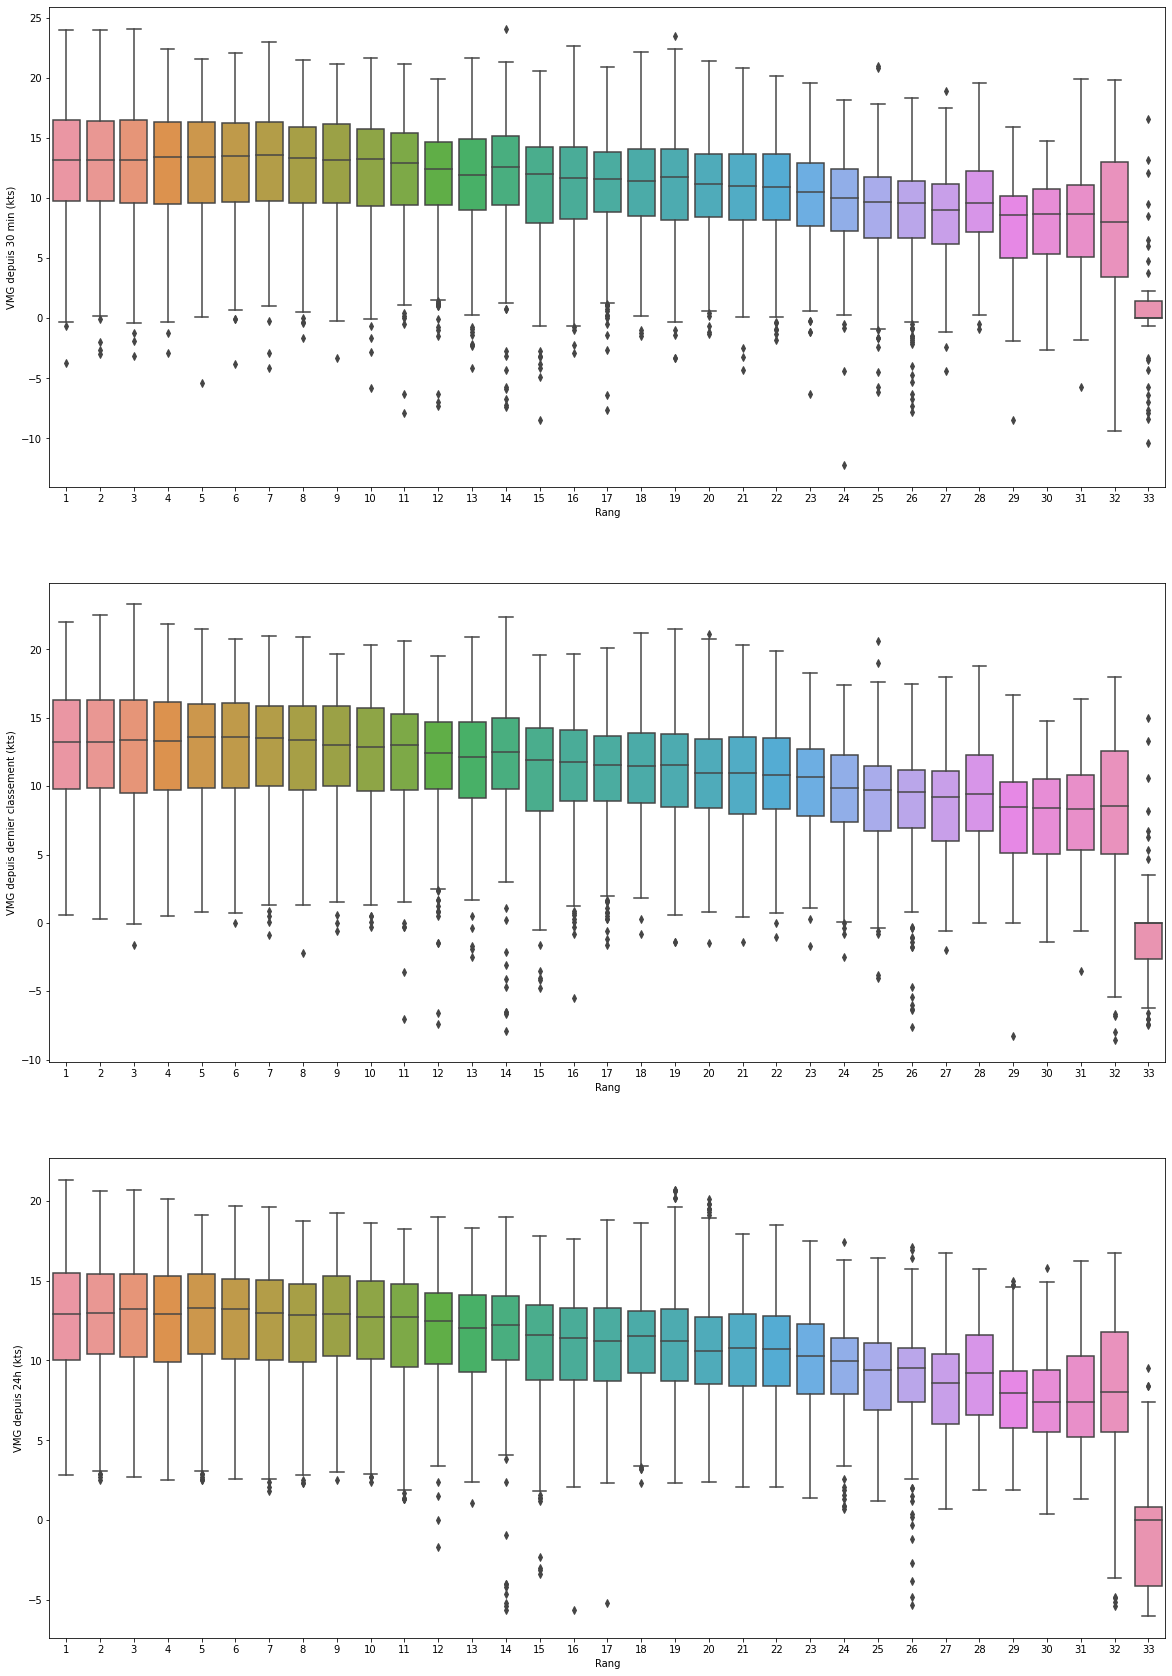

In [25]:
fig = plt.figure(figsize=(20,30))

for i, v in enumerate(var):
    ax = fig.add_subplot(3, 1, i+1)
    sns.boxplot(ax=ax, x="Rang", y=v, data=df_analyse)

plt.show()

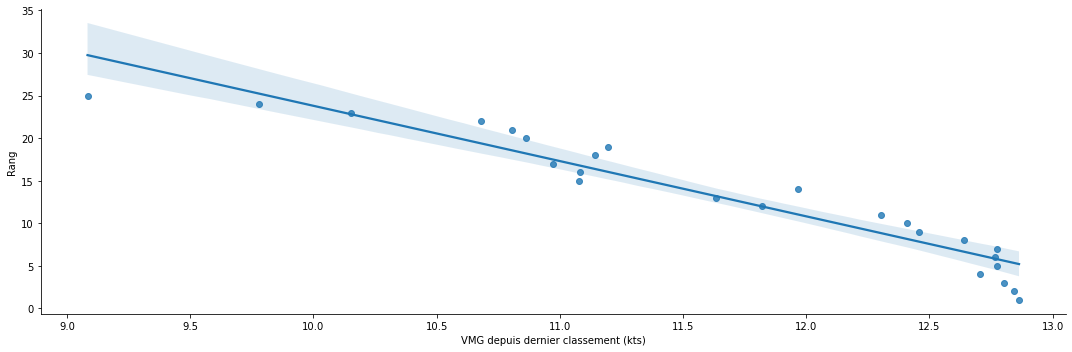

In [26]:
#régression linéaire du Rang en fonction de la 'VMG depuis dernier classement (kts)' moyenne en supprimant un outlier
df_lin_reg = df_analyse.groupby(['Rang']).agg({'VMG depuis dernier classement (kts)' : 'mean'})
sns.lmplot(x='VMG depuis dernier classement (kts)', y='Rang', data=df_lin_reg[:25].reset_index(), 
           height=5, aspect=3)

plt.show()

Les diagrammes en boîte et la régression linéaire nous permettent d'observer une corrélation entre le rang des skippers et la VMG (kts) pendant la course.

## B. Analyse de l'impact de la présence d'un foil sur la VMG et le rang du skipper

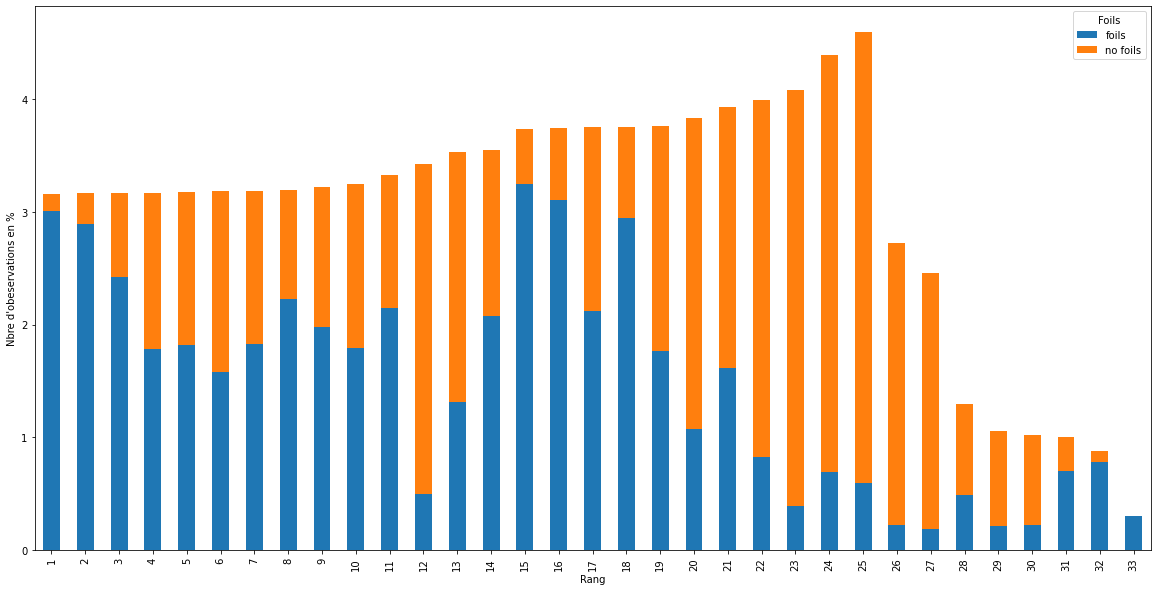

In [27]:
df_agg = df_analyse.pivot_table(values='Skipper', columns='Foils', index='Rang', aggfunc='count')
df_agg.apply(lambda x : x / df_analyse.shape[0] * 100).plot(kind='bar', stacked=True, figsize=(20,10))
plt.ylabel("Nbre d'obeservations en %")
plt.show()

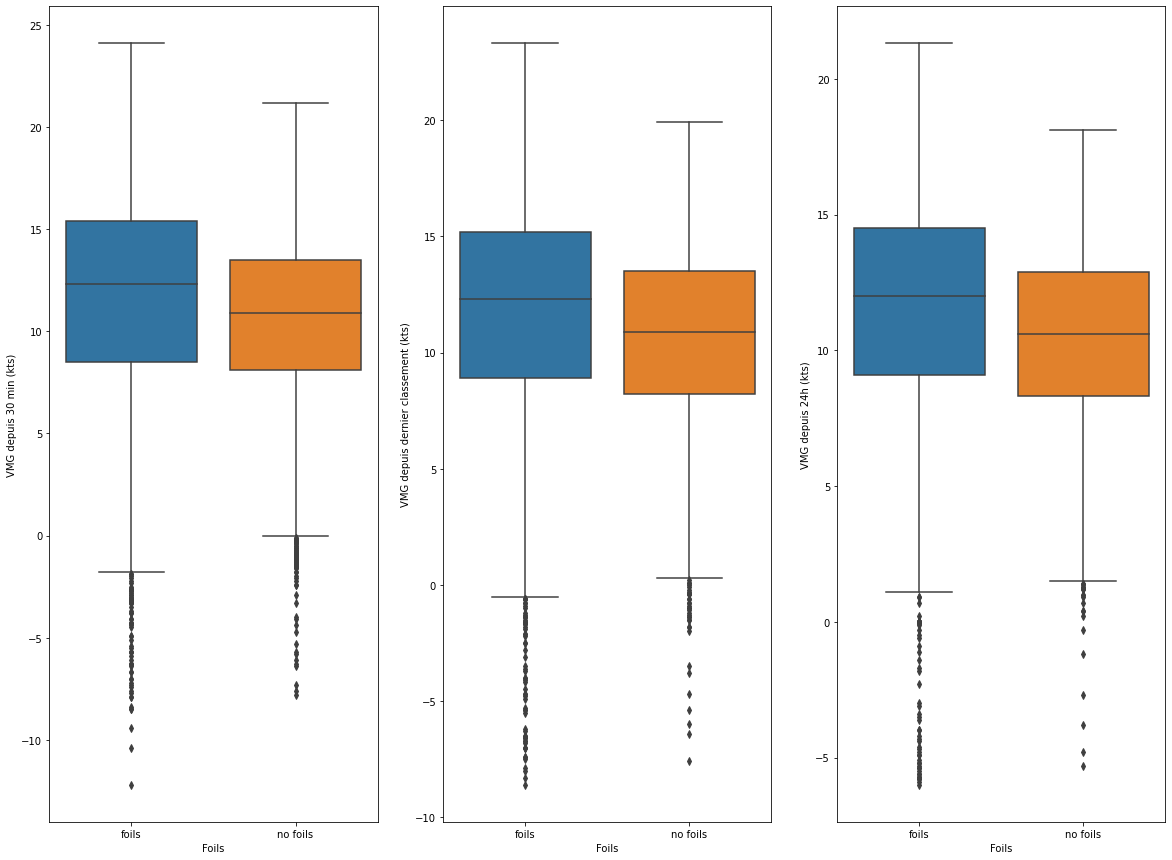

In [28]:
fig = plt.figure(figsize=(20,15))

for i, v in enumerate(var):
    ax = fig.add_subplot(1, 3, i+1)
    sns.boxplot(ax=ax, x="Foils", y=v, data=df_analyse)

plt.show()

L'histogramme et les diagrammes en boîte nous permettent d'observer une influence de la présence d'un foil sur les performances du voilier. En particulier, à partir du premier diagramme, nous remarquons que la proportion de voiliers avec un foil en tête du Vendée Globe est plus élevée que la proportion de voiliers sans foil en tête du Vendée Globe.

## C. Analyse de l'impact des autres variables (largeur, déplacement (poids), hauteur de mât, surface de voiles au près et surface de voiles au portant) sur la VMG

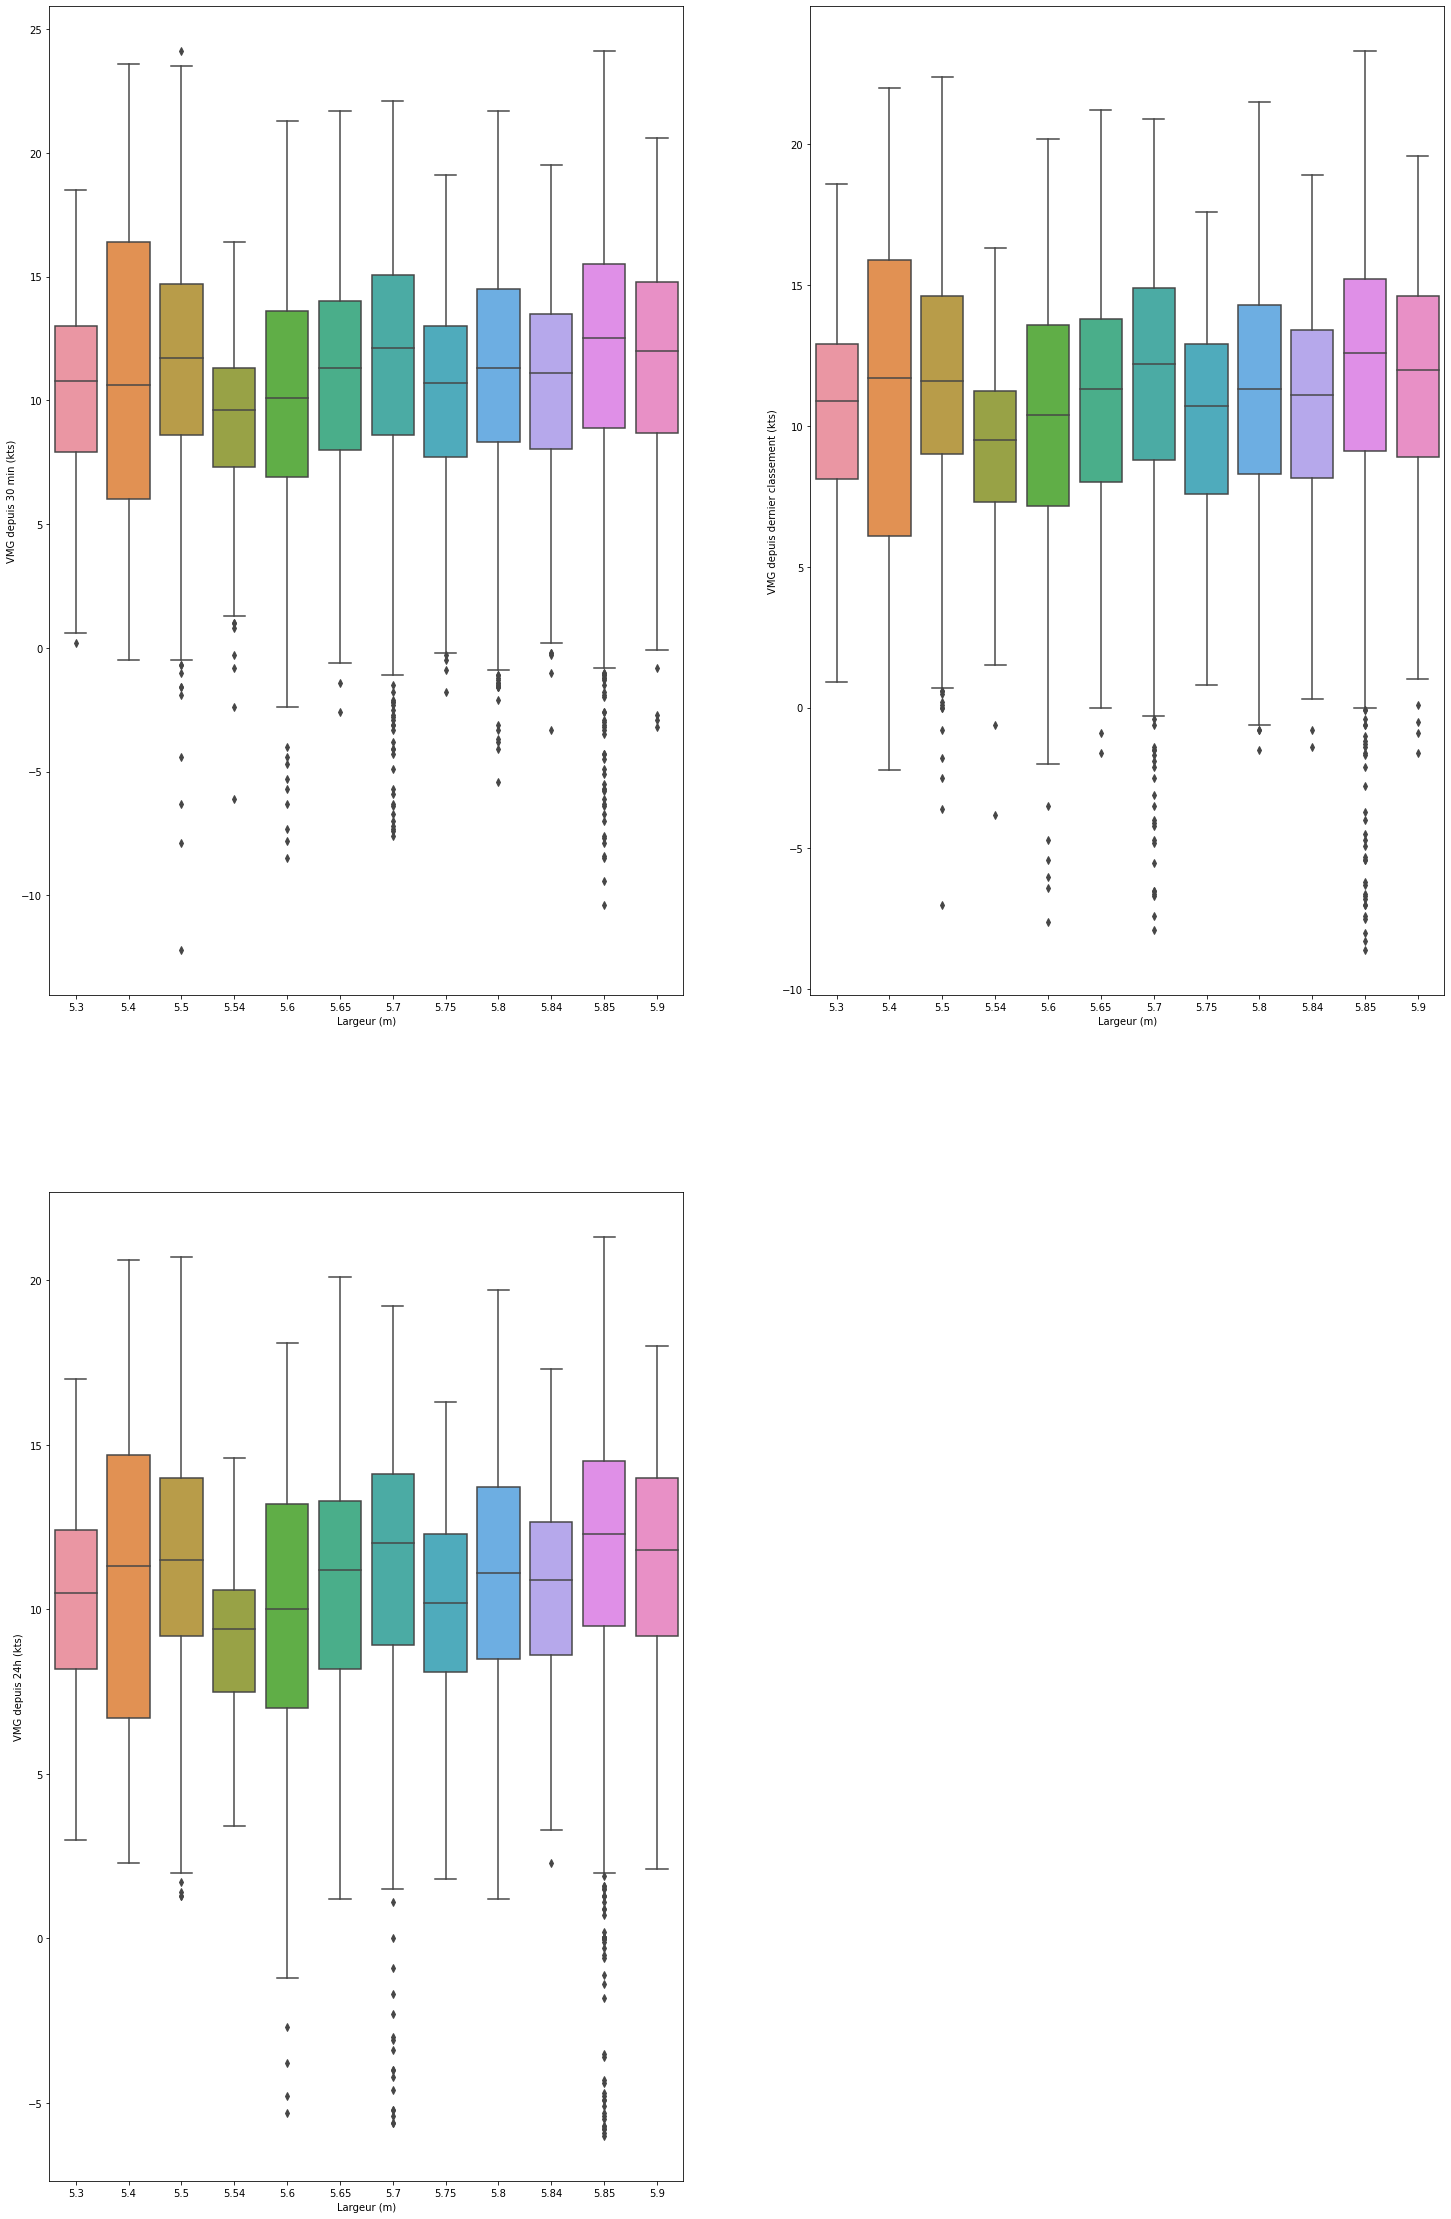

In [29]:
fig = plt.figure(figsize=(25,40))

for i, v in enumerate(var):
    ax = fig.add_subplot(2, 2, i+1)
    sns.boxplot(ax=ax, x="Largeur (m)", y=v, data=df_analyse)

plt.show()

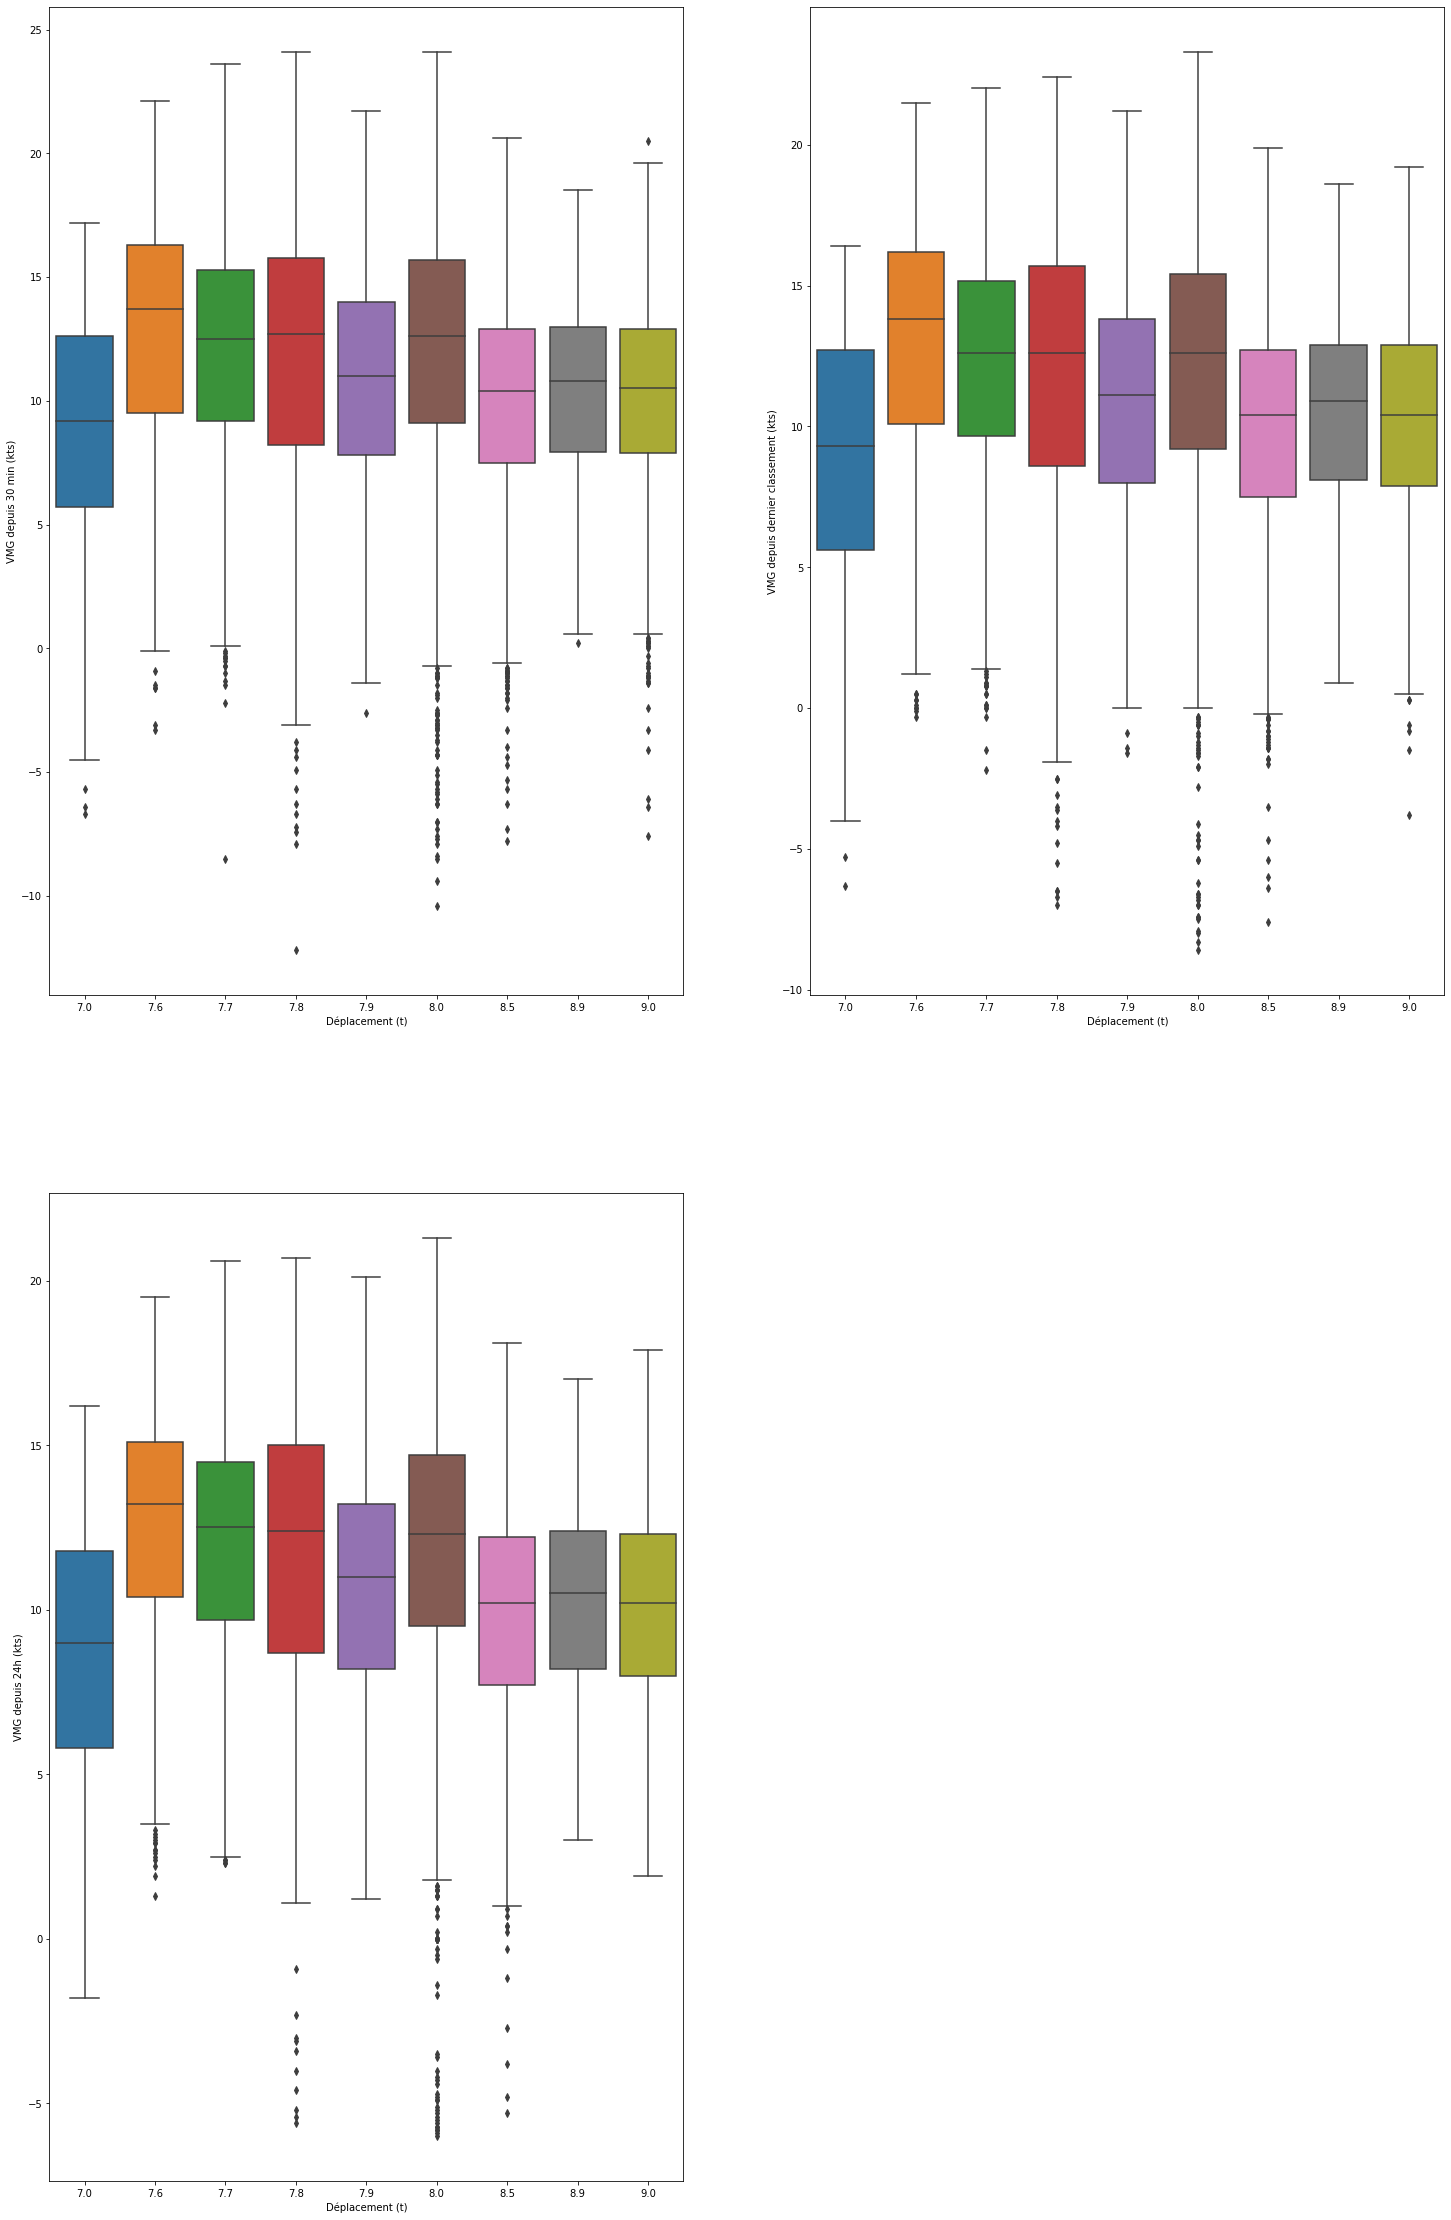

In [30]:
fig = plt.figure(figsize=(25,40))

for i, v in enumerate(var):
    ax = fig.add_subplot(2, 2, i+1)
    sns.boxplot(ax=ax, x="Déplacement (t)", y=v, data=df_analyse)

plt.show()

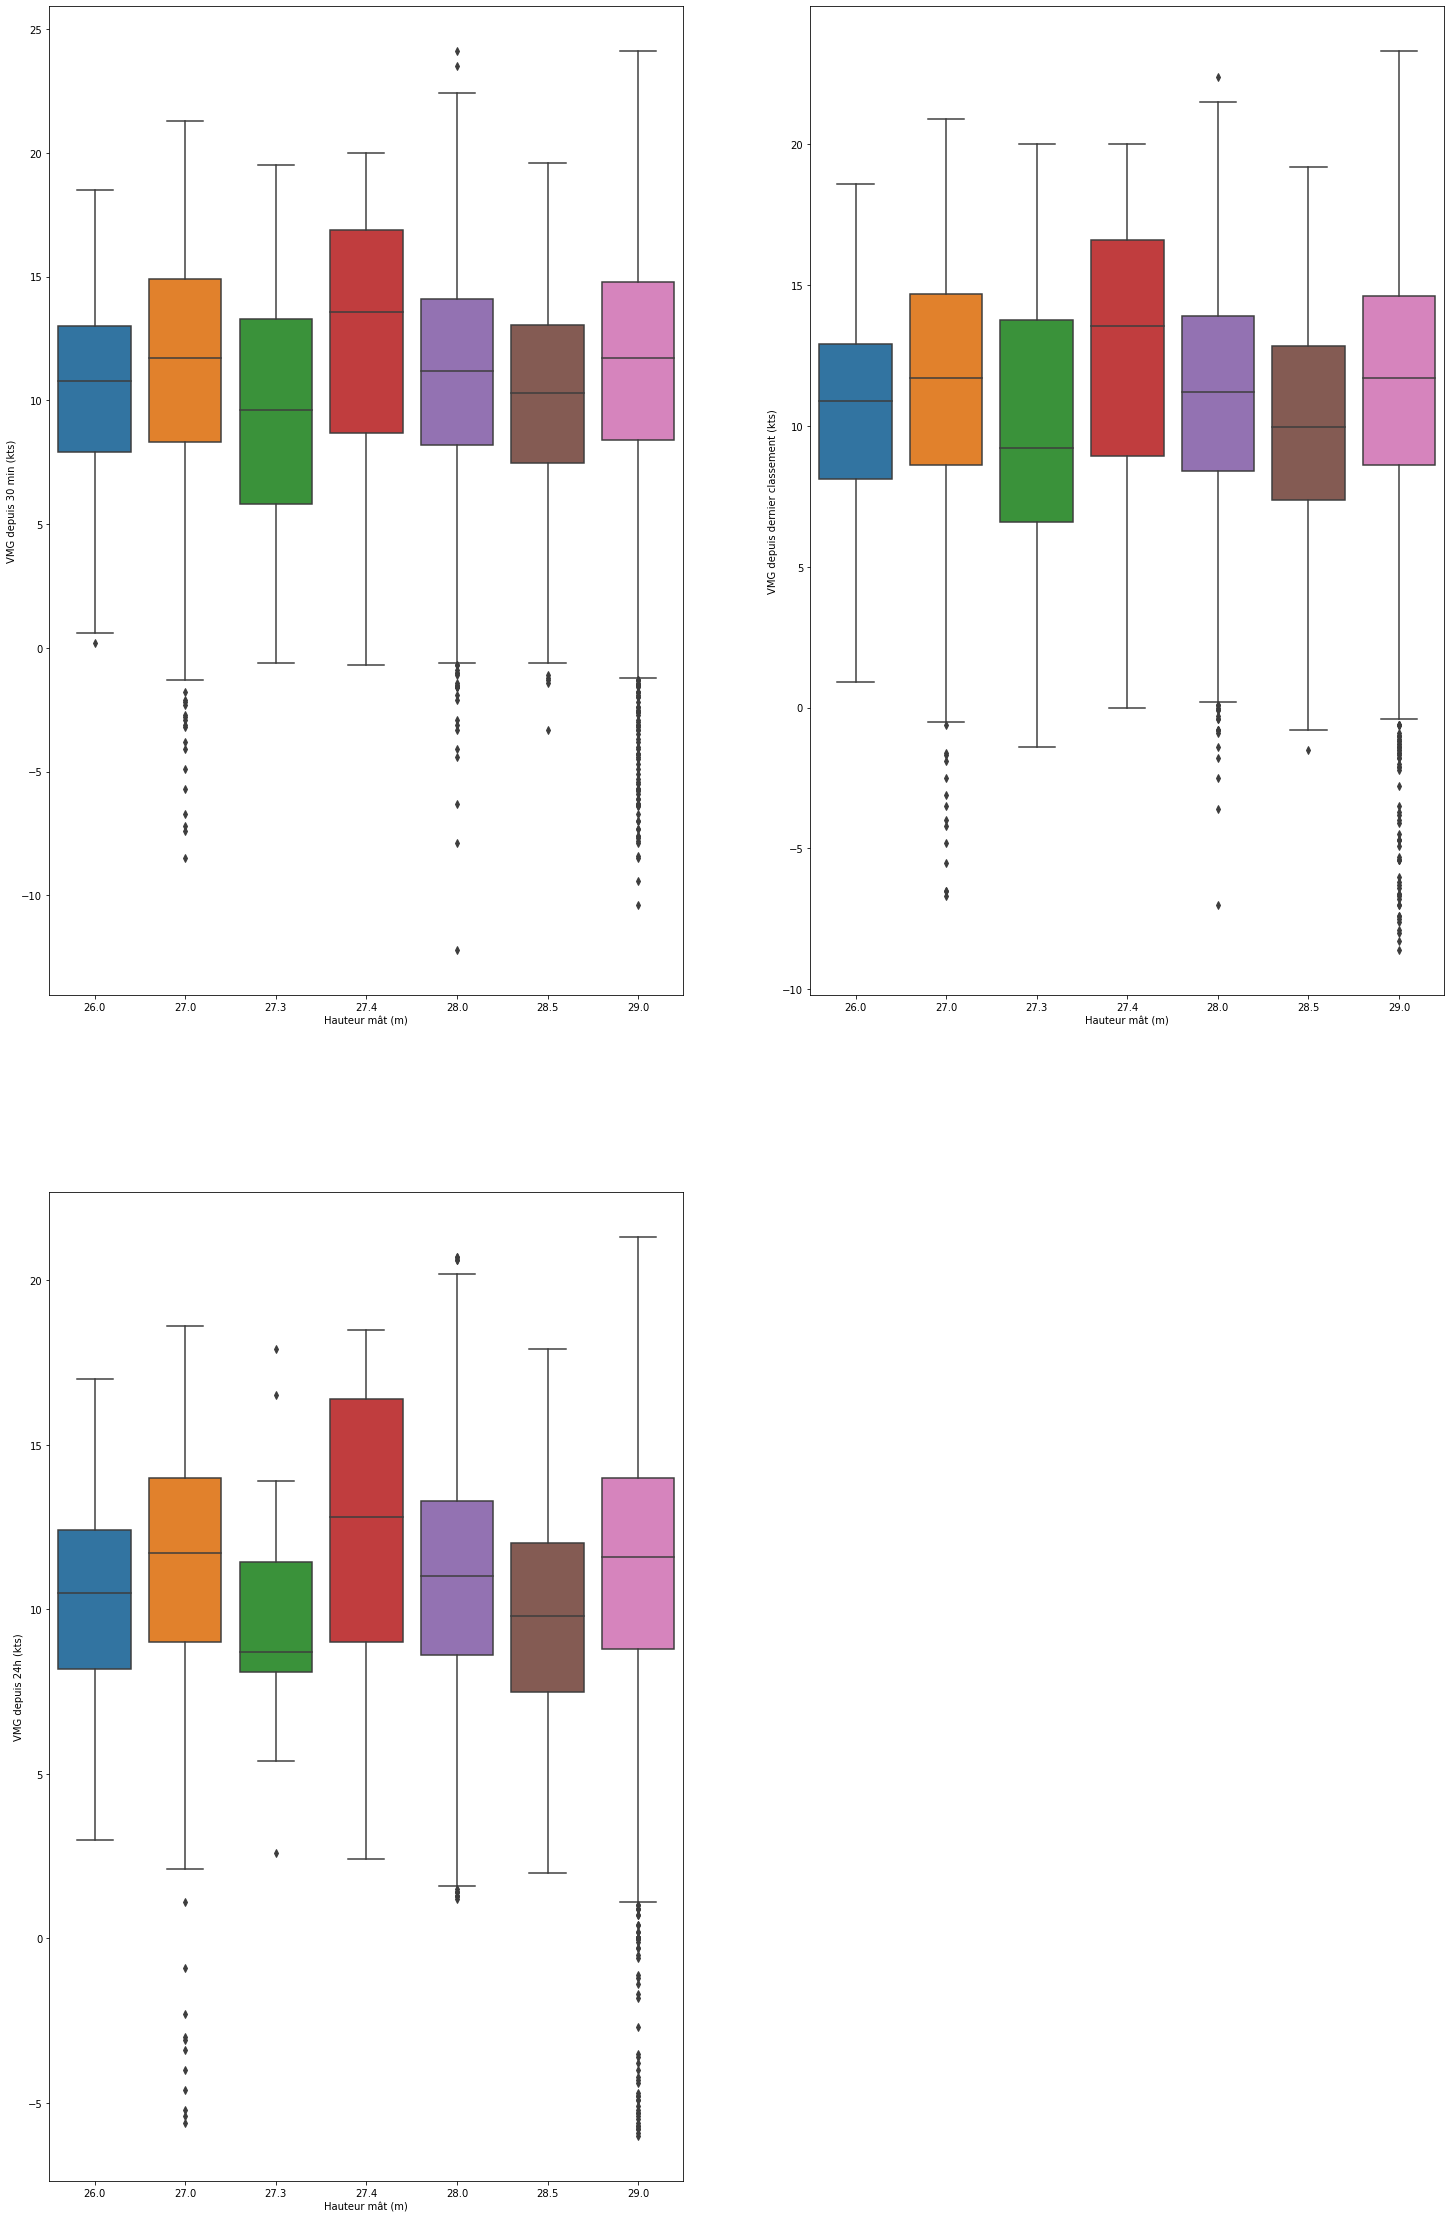

In [31]:
fig = plt.figure(figsize=(25,40))

for i, v in enumerate(var):
    ax = fig.add_subplot(2, 2, i+1)
    sns.boxplot(ax=ax, x="Hauteur mât (m)", y=v, data=df_analyse)

plt.show()

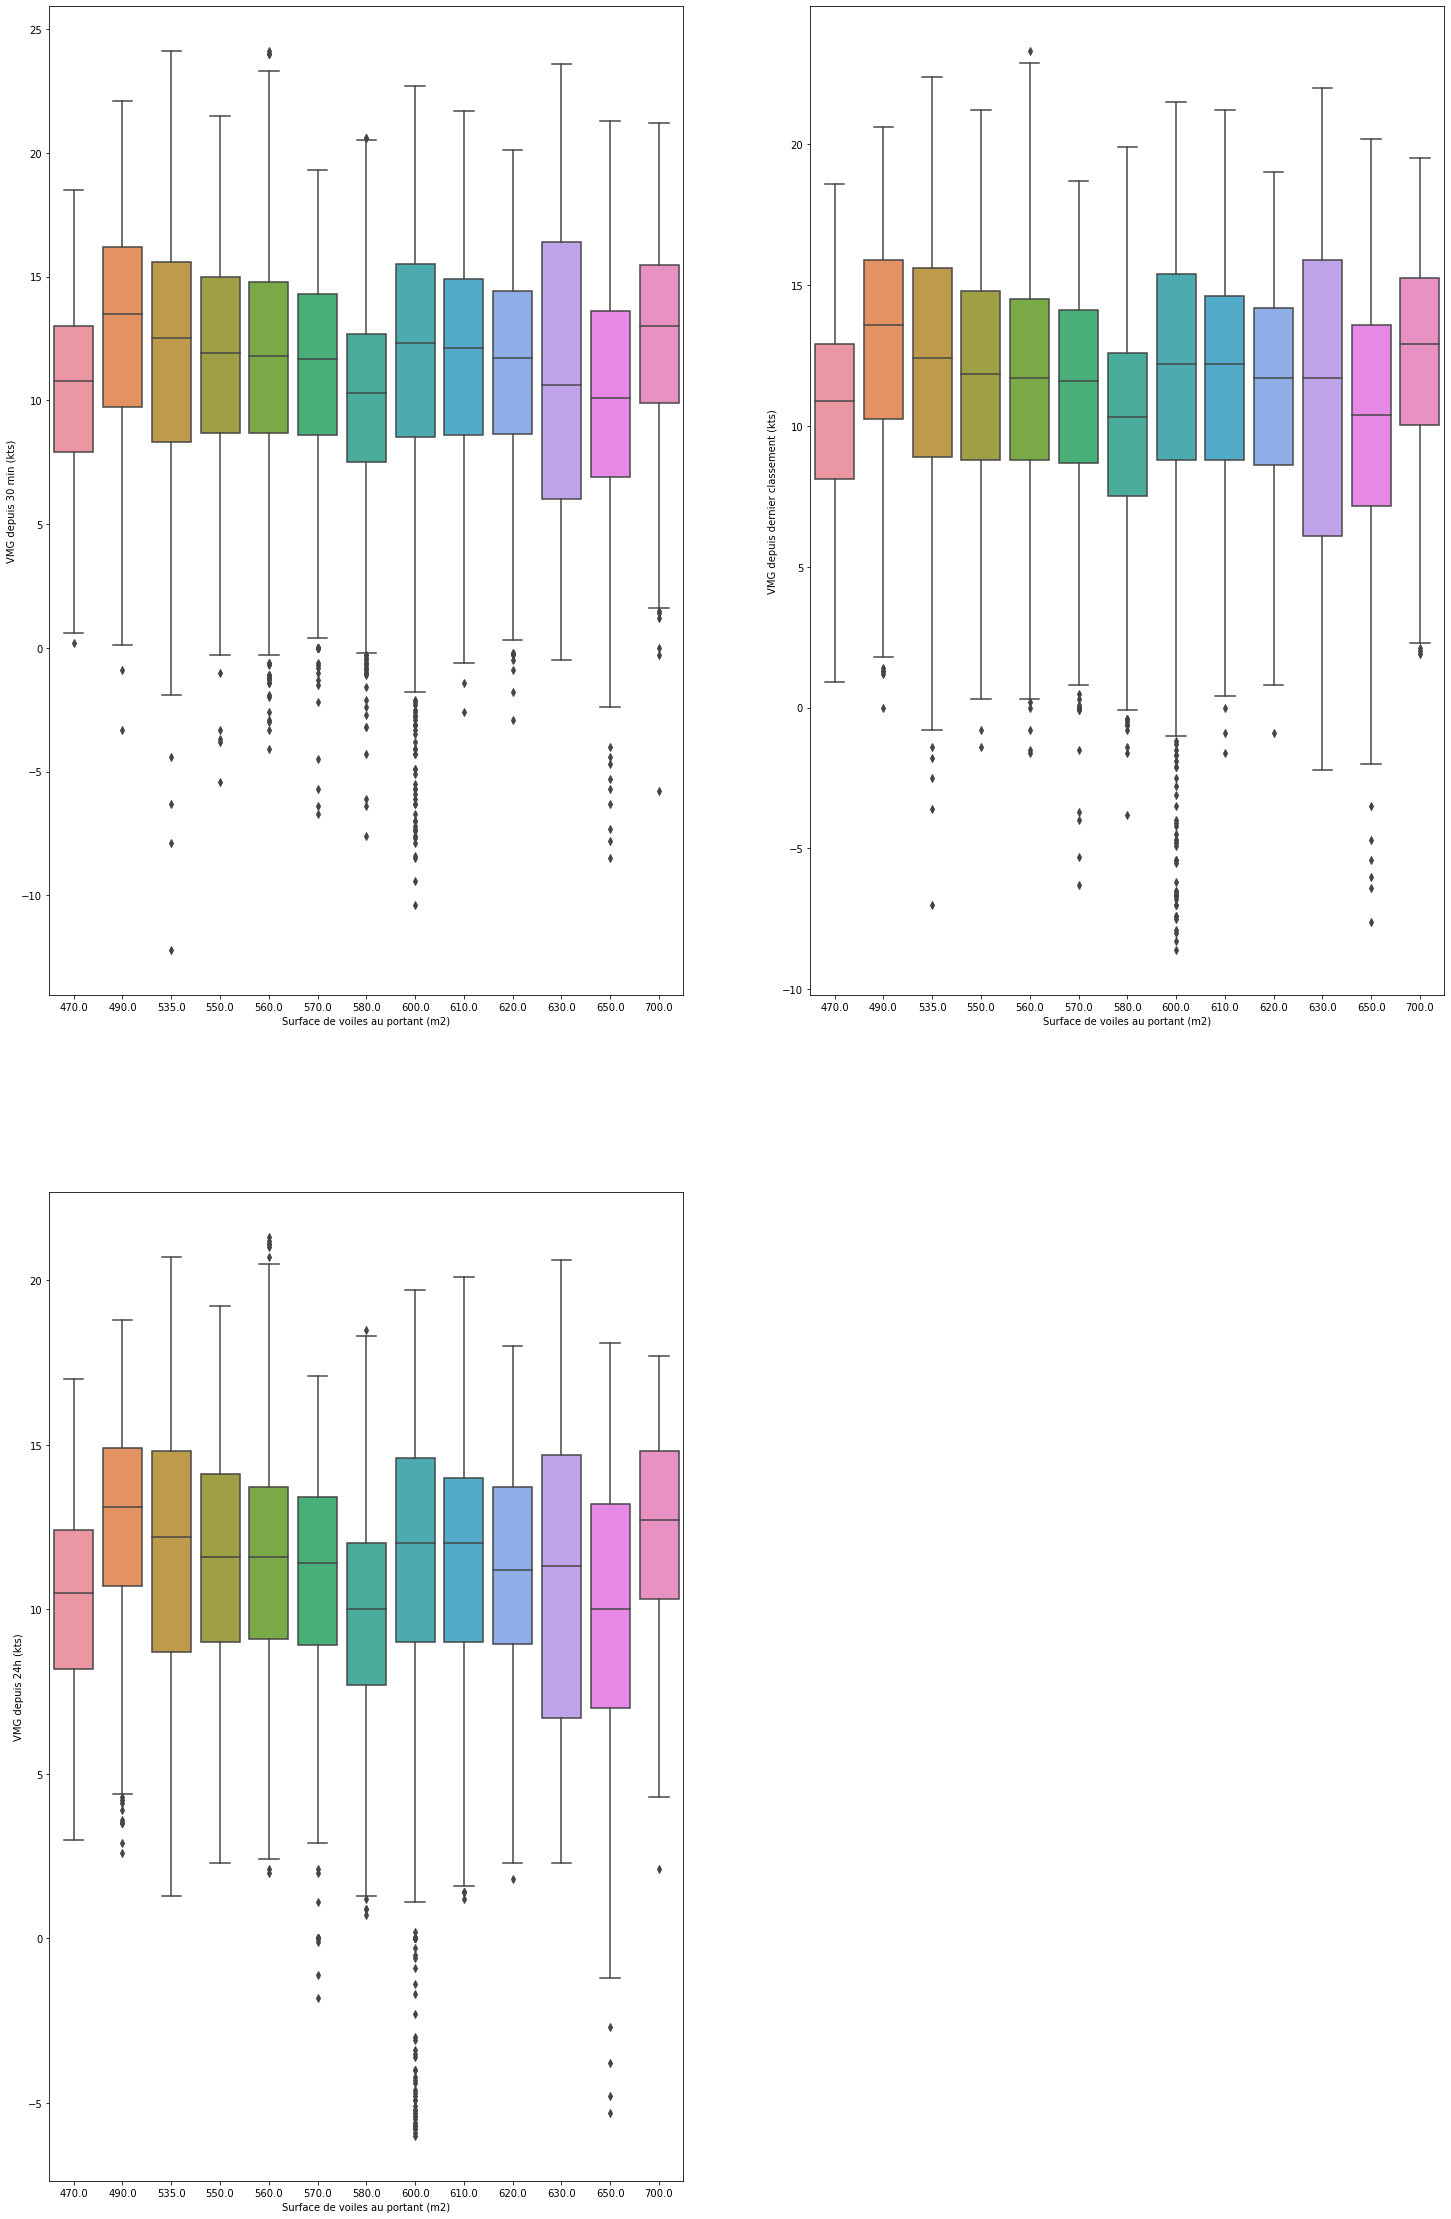

In [32]:
fig = plt.figure(figsize=(25,40))

for i, v in enumerate(var):
    ax = fig.add_subplot(2, 2, i+1)
    sns.boxplot(ax=ax, x="Surface de voiles au portant (m2)", y=v, data=df_analyse)

plt.show()

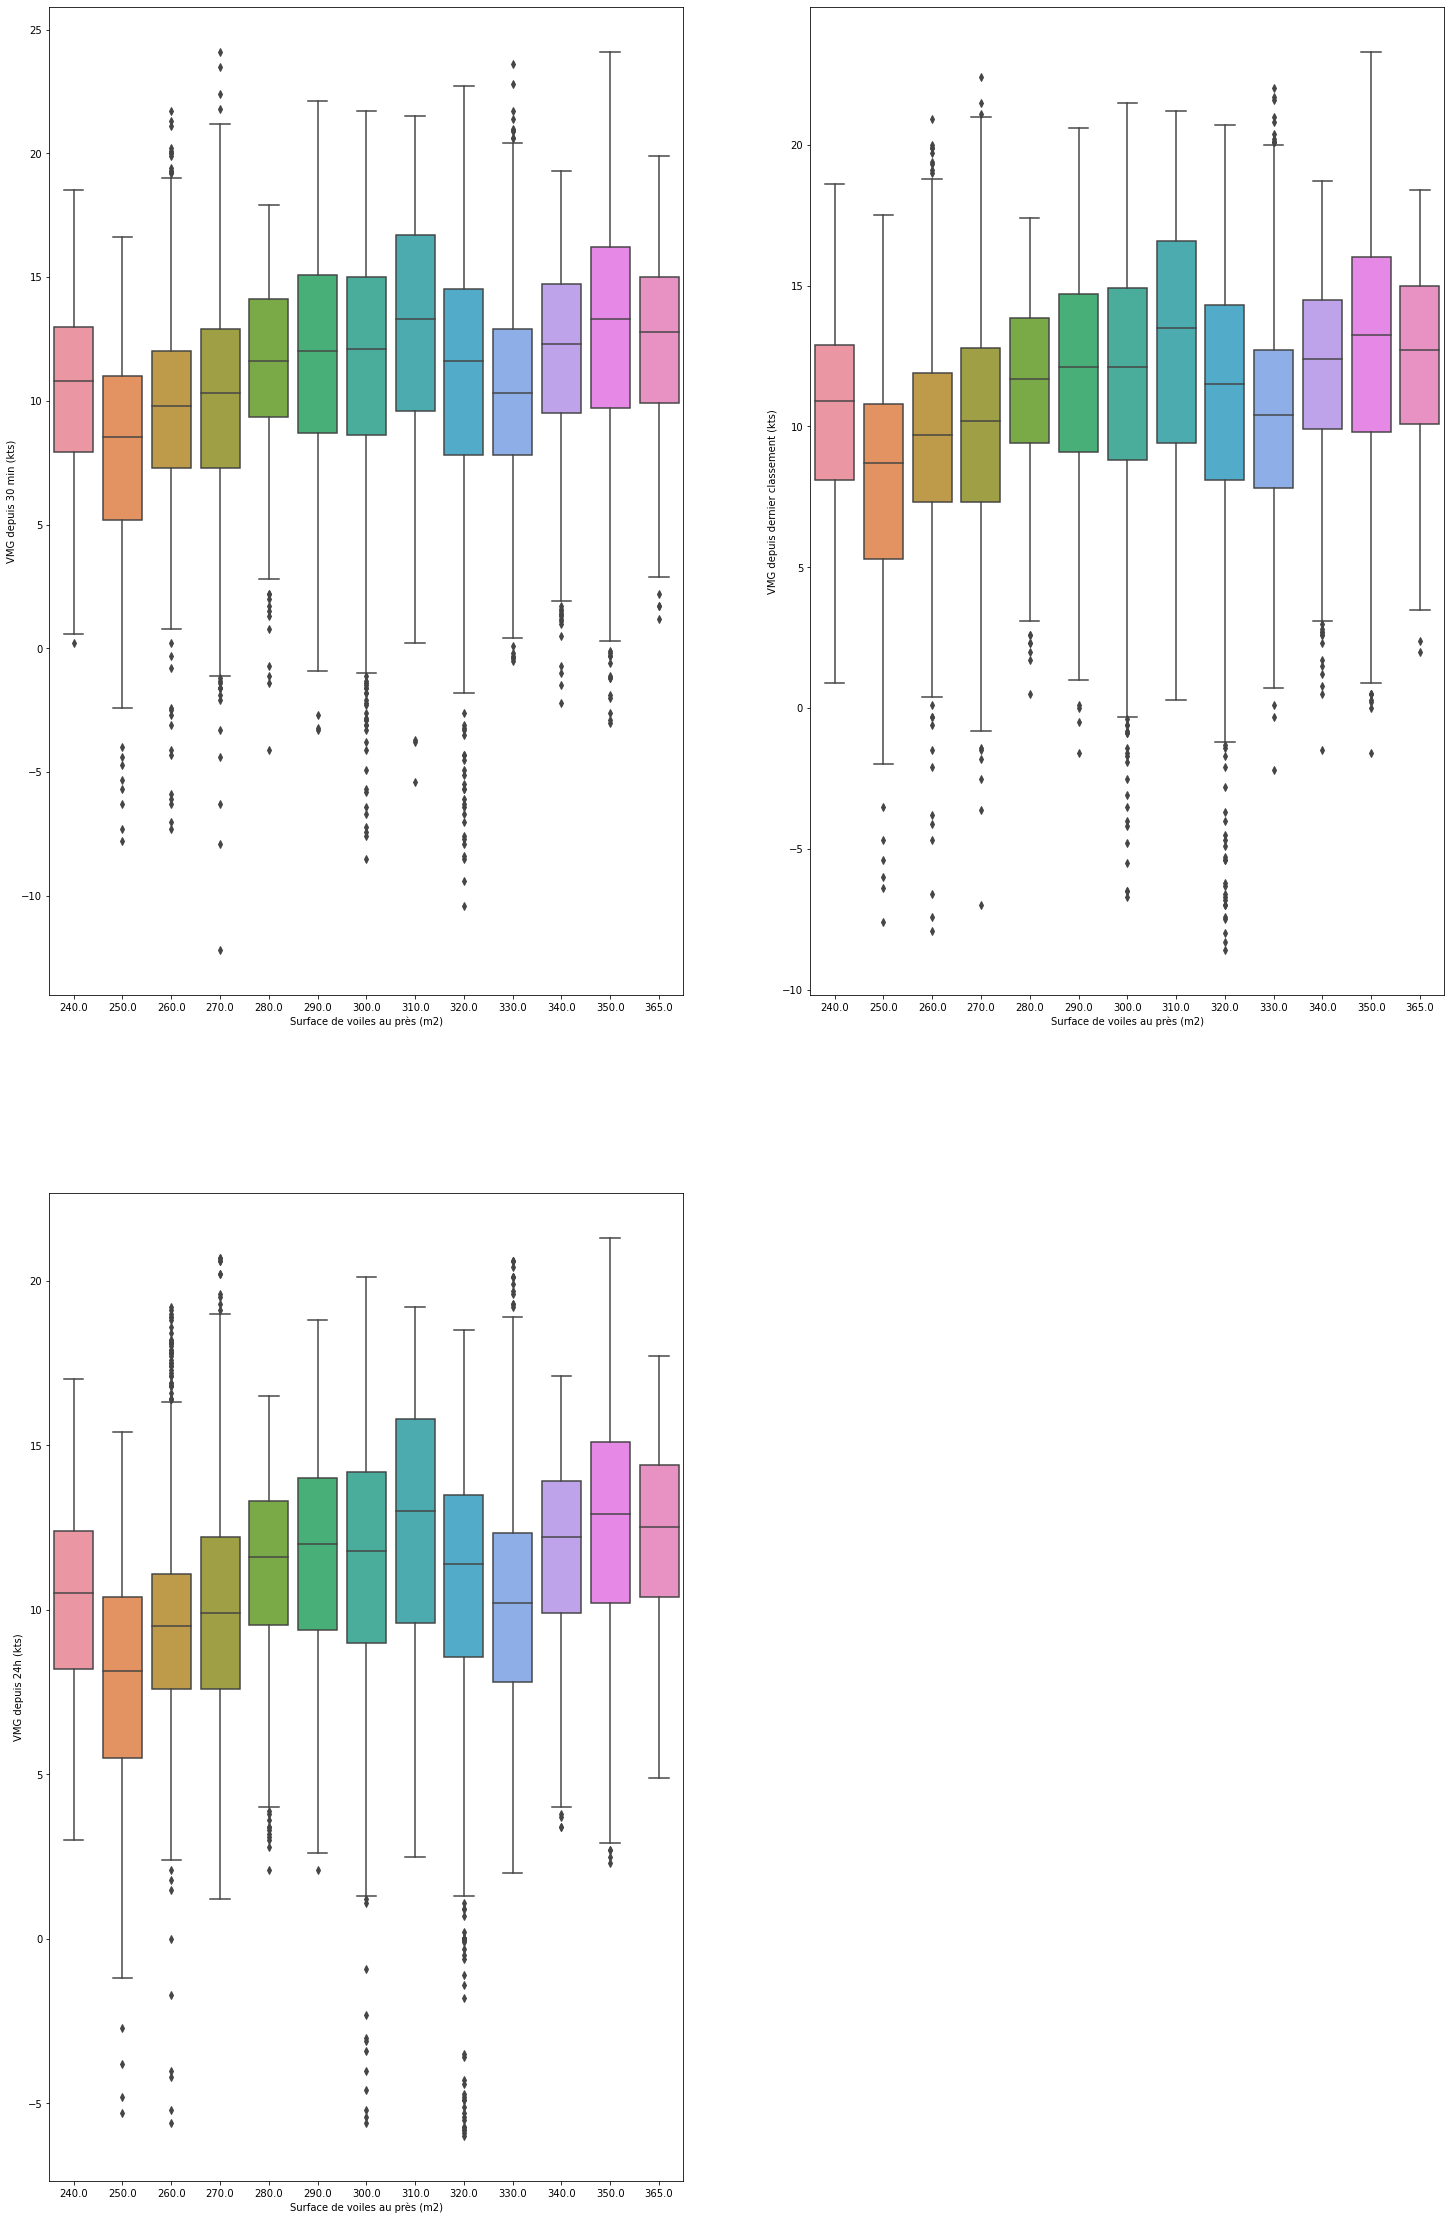

In [33]:
fig = plt.figure(figsize=(25,40))

for i, v in enumerate(var):
    ax = fig.add_subplot(2, 2, i+1)
    sns.boxplot(ax=ax, x='Surface de voiles au près (m2)', y=v, data=df_analyse)

plt.show()

L'analyse ne permet pas de conclure sur l'influence des autres variables (largeur, déplacement (poids), hauteur de mât, surface de voiles au près et surface de voiles au portant) sur la VMG.

## D. Représentation de séries temporelles (évolution du rang, évolution de la VMG, trajet parcouru par les skippers)

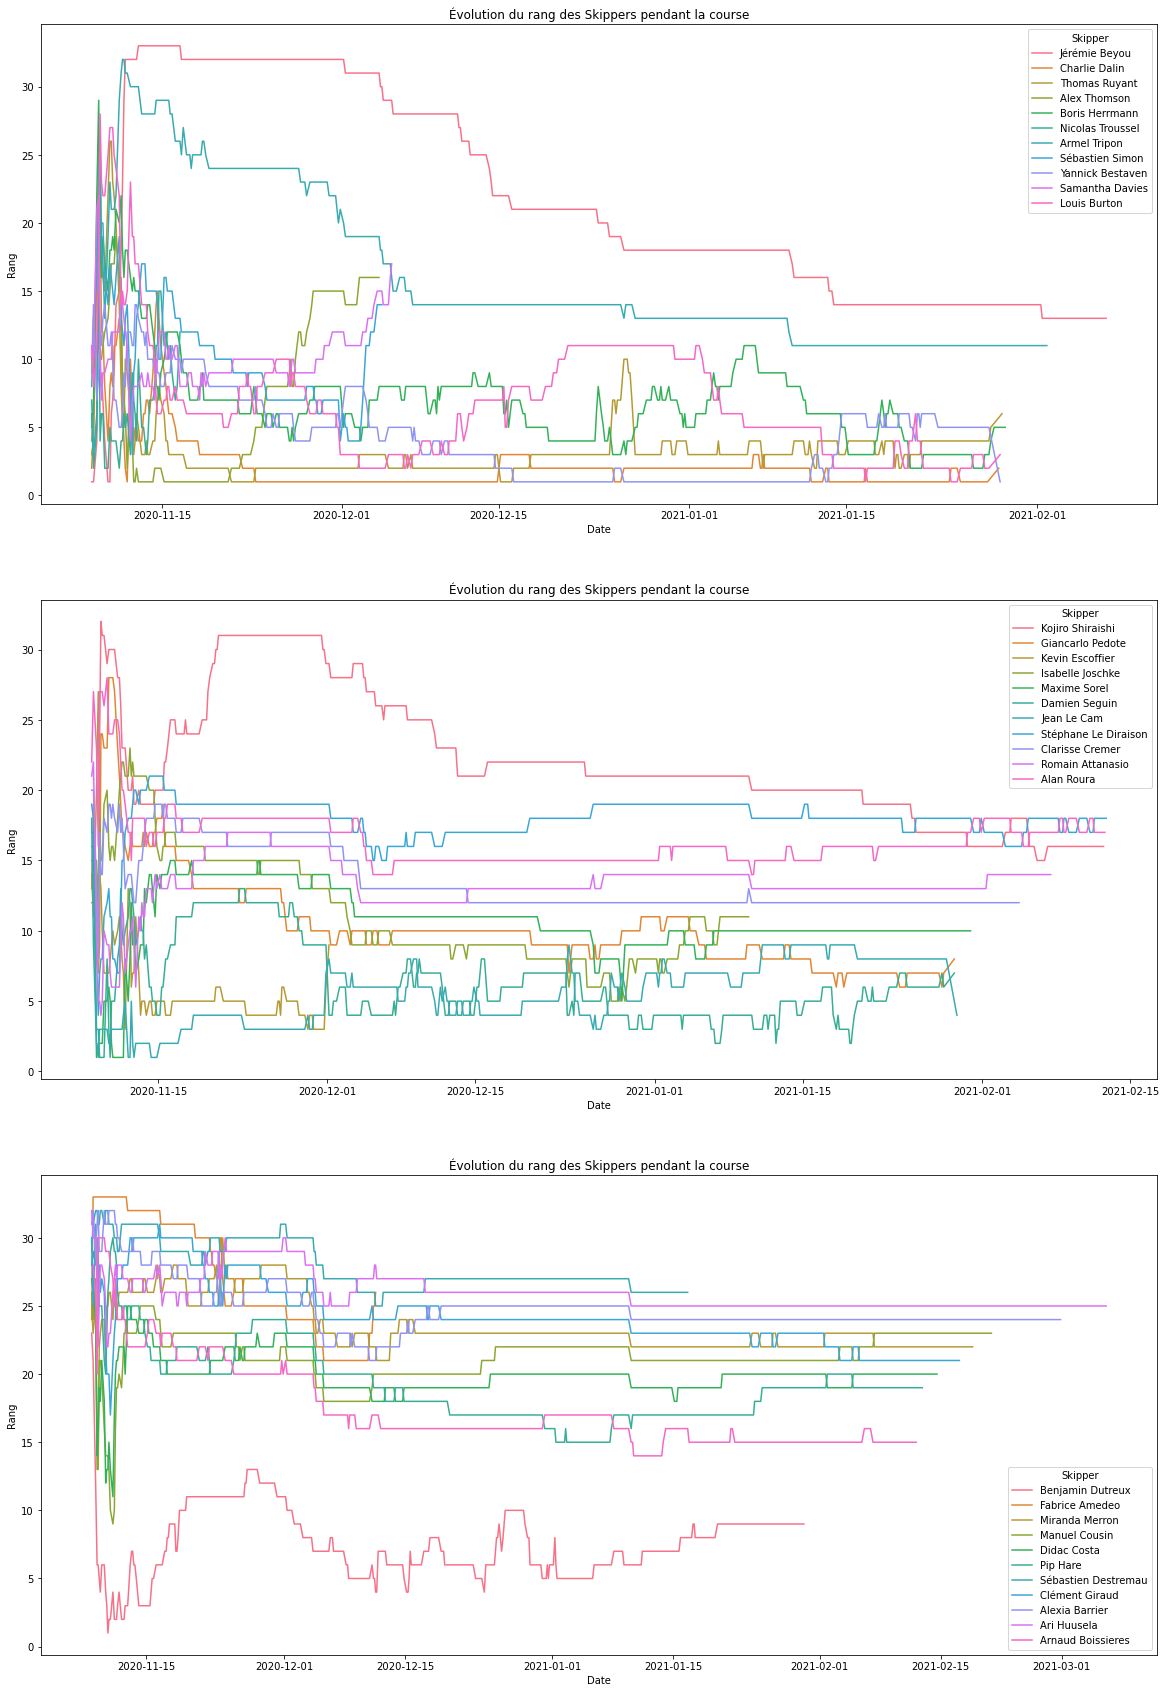

In [34]:
fig = plt.figure(figsize=(20,30))

mask =[]
for i in range(3):
    mask.append(df_analyse['Skipper'].unique()[i * int(len(df_analyse['Skipper'].unique())/3) : (i+1) * int(len(df_analyse['Skipper'].unique())/3)])
    
for i, m in enumerate(mask):
    ax = fig.add_subplot(3, 1, i+1)
    df_serie = df_analyse[df_analyse['Skipper'].str.contains('|'.join(m))]
    sns.lineplot(ax=ax, x='Date', y='Rang', data=df_serie, hue='Skipper')
    plt.title('Évolution du rang des Skippers pendant la course')

plt.show()

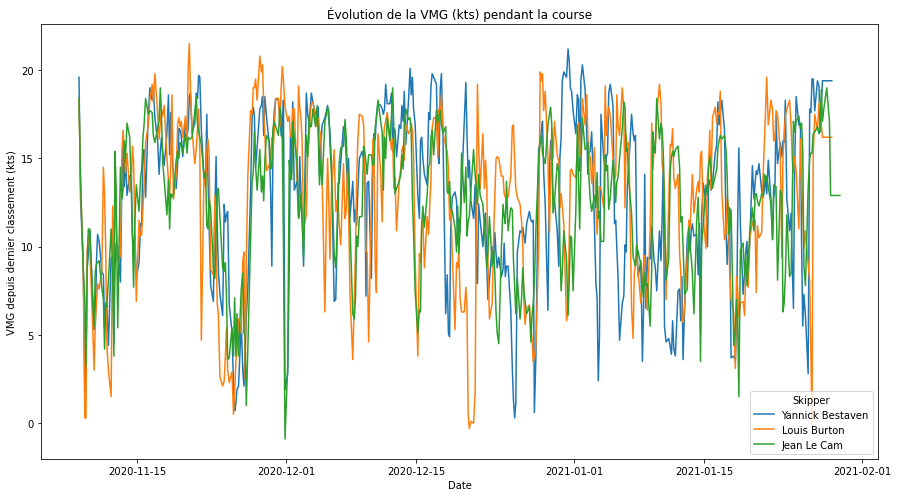

In [35]:
fig = plt.figure(figsize=(15,8))

skp = ['Jean Le Cam', 'Louis Burton', 'Yannick Bestaven']

df_serie_2 = df_analyse[df_analyse['Skipper'].str.contains('|'.join(skp))]
sns.lineplot(x='Date', y='VMG depuis dernier classement (kts)', data=df_serie_2, hue='Skipper')
plt.title('Évolution de la VMG (kts) pendant la course')

plt.show()

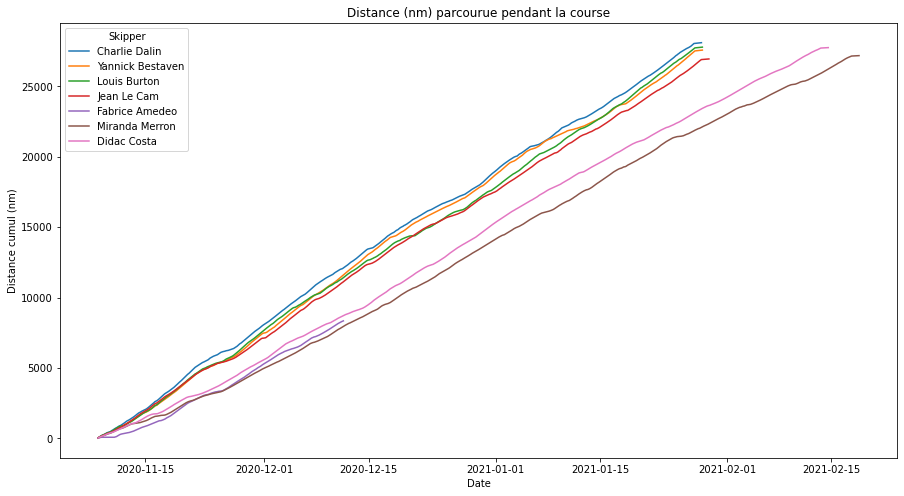

In [36]:
df_analyse_2 = df_analyse.copy()

for skp in df_analyse_2['Skipper'].unique():
    df_analyse_2.loc[df_analyse_2['Skipper'] == skp, 'Distance cumul (nm)'] = df_analyse_2.loc[df_analyse_2['Skipper'] == skp, 'Distance depuis dernier classement (nm)'].cumsum()

fig = plt.figure(figsize=(15,8))

skp = ['Jean Le Cam', 'Louis Burton', 'Yannick Bestaven', 'Charlie Dalin', 'Didac Costa', 'Miranda Merron', 'Fabrice Amedeo']

df_serie_3 = df_analyse_2[df_analyse_2['Skipper'].str.contains('|'.join(skp))]
sns.lineplot(x='Date', y='Distance cumul (nm)', data=df_serie_3, hue='Skipper')
plt.title('Distance (nm) parcourue pendant la course')

plt.show()

## E. Cartes avec les routes des voiliers

In [37]:
fig = px.line_geo(df_cleaned, 
                  lat='Latitude', lon='Longitude', color='Skipper',
                 facet_col='Skipper', facet_col_wrap=3, 
                  facet_col_spacing= 0.02, facet_row_spacing=0.02,
                 height=5000, width=3000)
fig.show()

## F. Analyse des relations entre les variables

In [38]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [39]:
X_foils = np.array(df_analyse['Foils']).reshape(-1,1)

enc = OneHotEncoder()
enc.fit(X_foils)

Foils_OHE = enc.transform(X_foils).toarray()

In [40]:
df_corr = df_analyse[['VMG depuis dernier classement (kts)', 'Largeur (m)', 'Déplacement (t)', 
                     'Surface de voiles au près (m2)', 'Surface de voiles au portant (m2)', 'Hauteur mât (m)']]

In [41]:
df_corr.insert(6, 'Foils OHE', Foils_OHE[:, 0])

In [42]:
scaler = StandardScaler().fit(df_corr)

In [43]:
df_corrCR = pd.DataFrame(scaler.transform(df_corr), columns=['VMG depuis dernier classement (kts)', 'Largeur (m)', 'Déplacement (t)', 
                     'Surface de voiles au près (m2)', 'Surface de voiles au portant (m2)', 'Hauteur mât (m)', 'Foils OHE'])

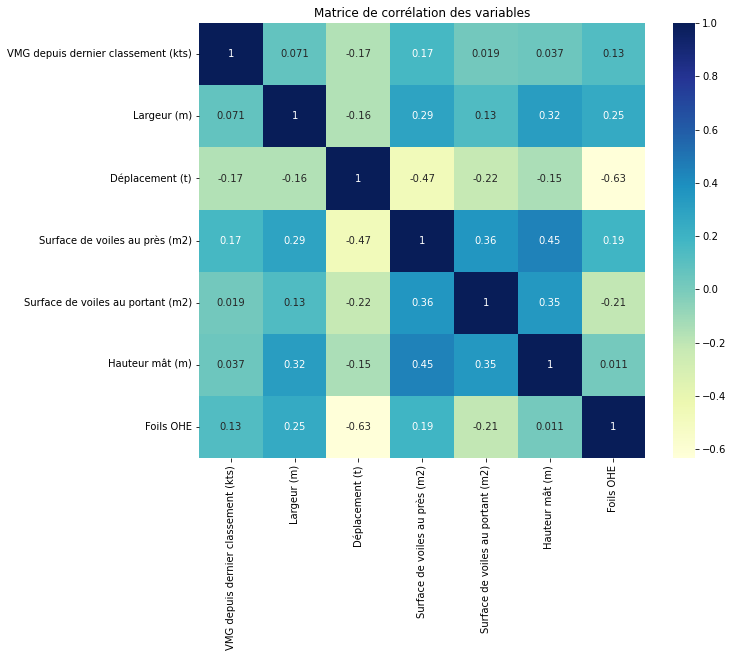

In [44]:
fig = plt.figure(figsize=(10,8))

sns.heatmap(df_corrCR.corr(), cmap="YlGnBu", annot=True);

plt.title("Matrice de corrélation des variables")
plt.show()

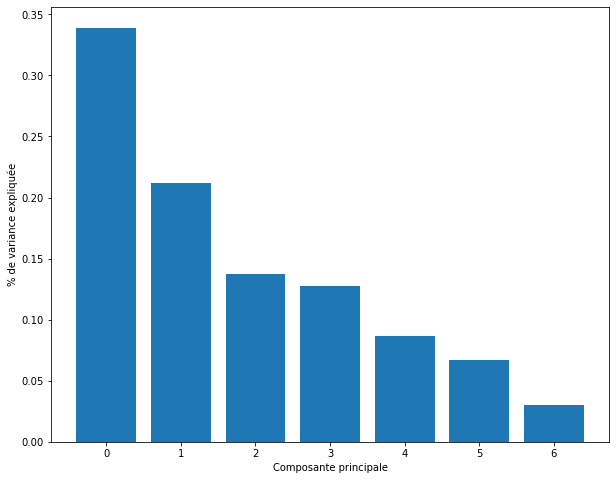

In [45]:
fig = plt.figure(figsize=(10,8))

pcaCR = PCA()
pcaCR.fit(df_corrCR)

ratios = pcaCR.explained_variance_ratio_

plt.bar(range(len(ratios)), ratios)
plt.xticks(range(len(ratios)))
plt.xlabel("Composante principale")
plt.ylabel("% de variance expliquée")
plt.show()

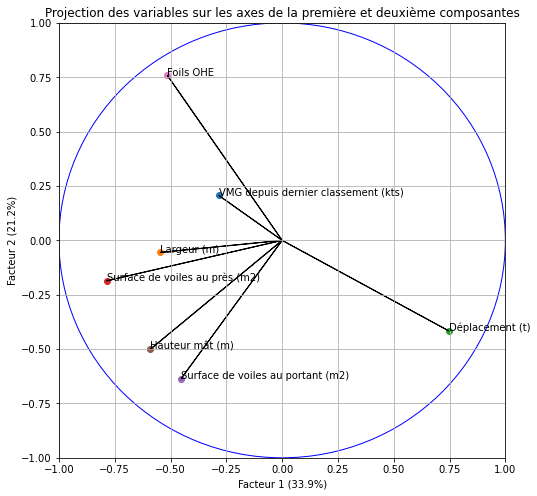

In [46]:
df_corrNt = pcaCR.transform(df_corrCR)

df_corrCRTranspose = np.array(df_corrCR).transpose()
irlambdas = 1/np.sqrt(pcaCR.explained_variance_)
mirlambdas = np.diagflat(irlambdas)
projectionsVars = (df_corrCRTranspose.dot(df_corrNt)).dot(mirlambdas)/df_corrCR.shape[0]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)
for i, var in enumerate(df_corrCR.columns):
        x,y = projectionsVars[i,0], projectionsVars[i,1]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, var)
        
ax.set_xlabel("Facteur 1 ({}%)".format(round(ratios[0] * 100, 1)))
ax.set_ylabel("Facteur 2 ({}%)".format(round(ratios[1] * 100, 1)))
plt.title("Projection des variables sur les axes de la première et deuxième composantes")
plt.grid()
plt.show()

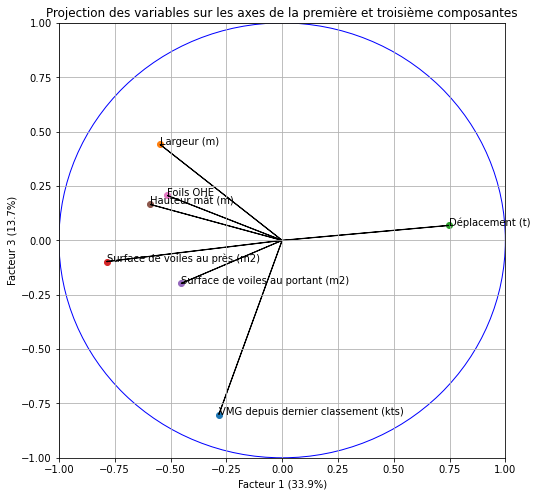

In [47]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)
for i, var in enumerate(df_corrCR.columns):
        x,y = projectionsVars[i,0], projectionsVars[i,2]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, var)
        
ax.set_xlabel("Facteur 1 ({}%)".format(round(ratios[0] * 100, 1)))
ax.set_ylabel("Facteur 3 ({}%)".format(round(ratios[2] * 100, 1))) 
plt.title("Projection des variables sur les axes de la première et troisième composantes")
plt.grid()
plt.show()

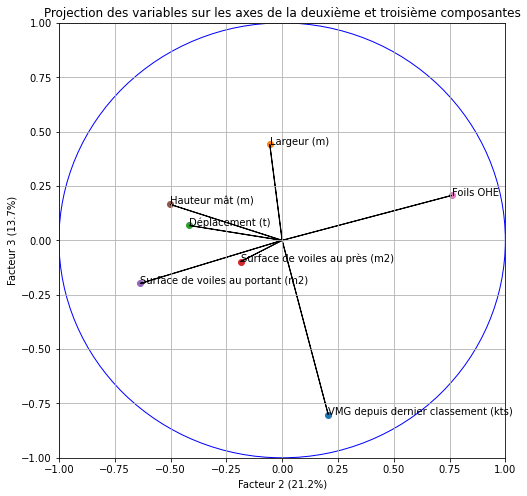

In [48]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
cercle = plt.Circle((0, 0), 1, color='b', fill=False)
ax.add_artist(cercle)
for i, var in enumerate(df_corrCR.columns):
        x,y = projectionsVars[i,1], projectionsVars[i,2]
        ax.scatter(x,y)
        ax.arrow(0, 0, x, y, shape='full', lw=1, length_includes_head=True)
        ax.text(x, y, var)

ax.set_xlabel("Facteur 2 ({}%)".format(round(ratios[1] * 100, 1)))
ax.set_ylabel("Facteur 3 ({}%)".format(round(ratios[2] * 100, 1)))    
plt.title("Projection des variables sur les axes de la deuxième et troisième composantes")
plt.grid()
plt.show()

La matrice de corrélation et les projections des variables sur les 3 premiers axes principaux nous permettent d'identifier une corrélation négative entre le déplacement et la présence d'un foil.

# 4. Application d'algorithmes de Machine Learning afin de prédire à quel segment appartient un skipper

Nous allons segmenter le rang des skippers en 4 classes : 
- Les skippers entre le rang 1 et 5 seront assignés à la classe 1
- Les skippers entre le rang 6 et 10 seront assignés à la classe 2
- Les skippers entre le rang 11 et 15 seront assignés à la classe 3
- Les autres skippers (rang supérieur à 15) seront assignés à la classe 4

Notre objectif sera de prédire la classe du skipper à partir des variables suivantes : 
- 'VMG depuis dernier classement (kts)'
- 'Foils'
- 'Largeur (m)' 
- 'Surface de voiles au près (m2)' 
- 'Surface de voiles au portant (m2)' 
- 'Hauteur mât (m)'
- 'Déplacement (t)'

Pour répondre à cette problématique, nous utiliserons trois familles d'algorithmes (modèle linéaire, modèle à noyau et modèle ensembliste) de classification supervisée. Nous testerons ainsi, un modèle de régression logistique, SVM et XGBoost et nous évaluerons leurs performances.

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score

In [50]:
def top_rang(x):
    if x <= 5:
        x = 1
    elif (x > 5) and (x <= 10):
        x = 2
    elif (x > 10) and (x <= 20):
        x = 3
    else:
        x = 4
    return x

In [51]:
df_ml = df_analyse.copy()

In [52]:
df_ml.insert(1, 'Top Rang', df_ml['Rang'].apply(top_rang))
df_ml.insert(31, 'Foils OHE', Foils_OHE[:, 0])

In [53]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15200 entries, 0 to 15207
Data columns (total 35 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Rang                                     15200 non-null  int64         
 1   Top Rang                                 15200 non-null  int64         
 2   Nation                                   15200 non-null  object        
 3   # Voile                                  15200 non-null  object        
 4   Skipper                                  15200 non-null  object        
 5   Bateau                                   15200 non-null  object        
 6   Date                                     15200 non-null  datetime64[ns]
 7   Heure FR                                 15200 non-null  object        
 8   Latitude                                 15200 non-null  float64       
 9   Longitude                              

In [54]:
X, y = df_ml[['VMG depuis dernier classement (kts)', 'Foils OHE',
                     'Largeur (m)', 'Hauteur mât (m)',
                  'Surface de voiles au portant (m2)', 'Surface de voiles au près (m2)',
             'Déplacement (t)']], df_ml['Top Rang']

scaler = StandardScaler()
scaler.fit(X)
X_CR = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_CR, y, test_size=0.2)

names = ['Régression Logistique', 'SVM', 'XGBoost']

classifiers = [LogisticRegression(multi_class='ovr'), 
               SVC(decision_function_shape='ovr'), 
               GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
              ]

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print('{} :'.format(name))
    print(metrics.classification_report(y_test, clf.predict(X_test)))

Régression Logistique :
              precision    recall  f1-score   support

           1       0.53      0.45      0.49       480
           2       0.47      0.37      0.41       457
           3       0.52      0.60      0.55      1083
           4       0.68      0.68      0.68      1020

    accuracy                           0.57      3040
   macro avg       0.55      0.52      0.53      3040
weighted avg       0.57      0.57      0.56      3040

SVM :
              precision    recall  f1-score   support

           1       0.69      0.77      0.73       480
           2       0.58      0.71      0.64       457
           3       0.80      0.78      0.79      1083
           4       0.94      0.81      0.87      1020

    accuracy                           0.78      3040
   macro avg       0.75      0.77      0.76      3040
weighted avg       0.79      0.78      0.78      3040

XGBoost :
              precision    recall  f1-score   support

           1       0.67      0.81  

In [55]:
import warnings
warnings.filterwarnings('ignore')

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    print('{} :'.format(name))
    cross_val = cross_val_score(clf, X_CR, y, cv=10)
    cross_val_mean = np.mean(cross_val)
    cross_val_std = np.std(cross_val)
    print("Score CV moy : {} (+/-) {}".format('%.3e'%cross_val_mean, '%.3e'%cross_val_std))

Régression Logistique :
Score CV moy : 5.505e-01 (+/-) 8.473e-02
SVM :
Score CV moy : 7.153e-01 (+/-) 1.231e-01
XGBoost :
Score CV moy : 7.158e-01 (+/-) 1.355e-01


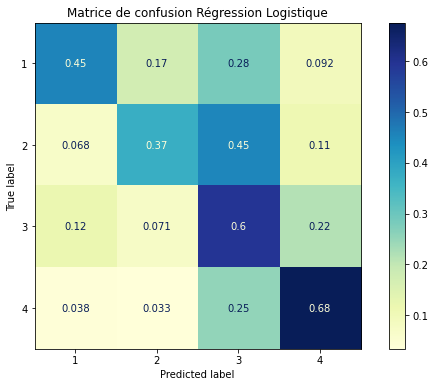

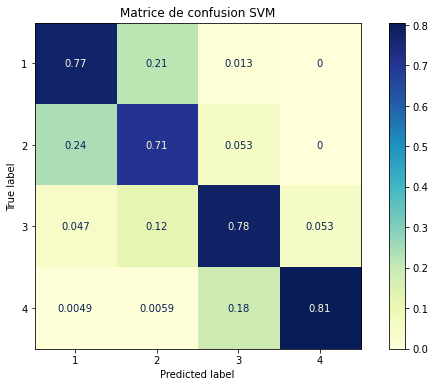

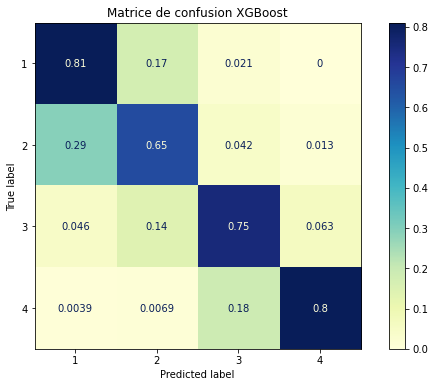

In [56]:
#la diagonale de la matrice de confusion correspond aux taux de vrai positif
for name, clf in zip(names, classifiers):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Matrice de confusion {}'.format(name))

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, ax = ax, cmap="YlGnBu", normalize='true')
    disp.confusion_matrix

    plt.show()

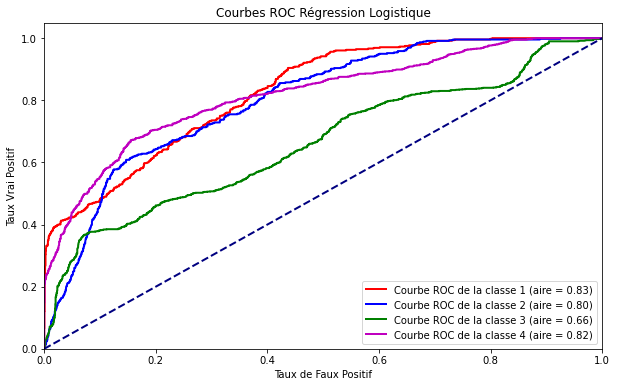

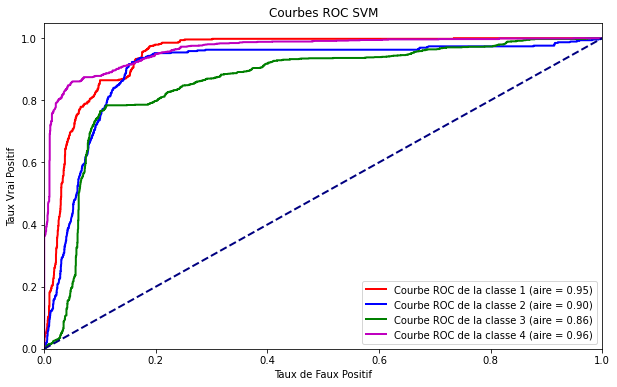

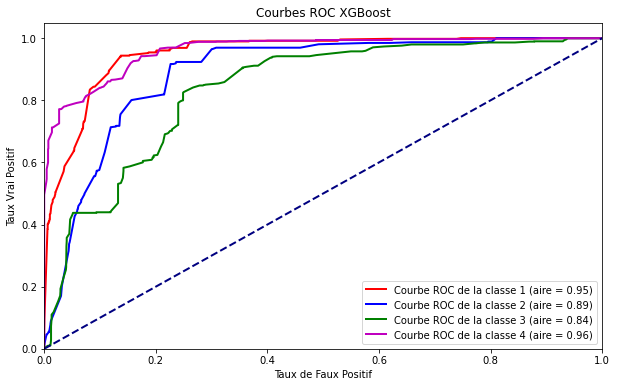

In [57]:
#Transformation du vecteur y_test en matrice binaire de dimension n x nbre de classe
y_test_bin = label_binarize(y_test, classes=df_ml['Top Rang'].unique())
n_classes = y_test_bin.shape[1]

for name, clf in zip(names, classifiers):

    y_score = clf.fit(X_train, y_train).decision_function(X_test)

    #Calcul de la courbe et de l'aire de la courbe ROC pour chaque classe
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    lw = 2
    colors = ['r', 'b', 'g', 'm',]

    for i, color in enumerate(colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="Courbe ROC de la classe {0} (aire = {1:0.2f})".format(i+1, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("Taux de Faux Positif")
    plt.ylabel("Taux Vrai Positif")
    plt.title("Courbes ROC {}".format(name))
    plt.legend(loc="lower right")
    plt.show()

In [58]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

Importance des coefficients de la régression logistique pour la classe 1


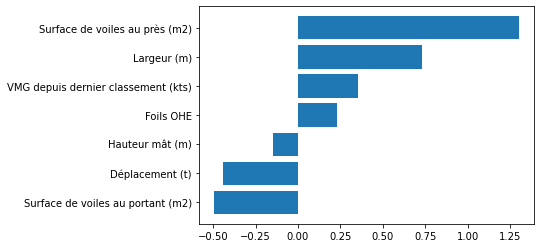

Importance des coefficients de la régression logistique pour la classe 2


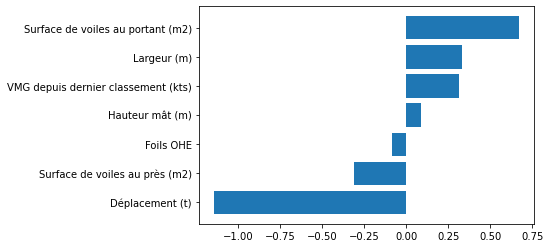

Importance des coefficients de la régression logistique pour la classe 3


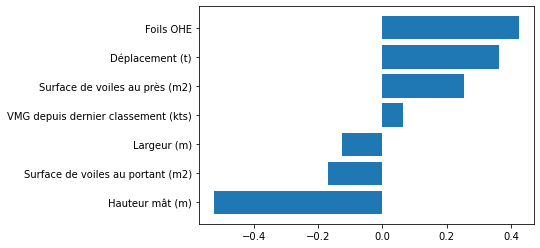

Importance des coefficients de la régression logistique pour la classe 4


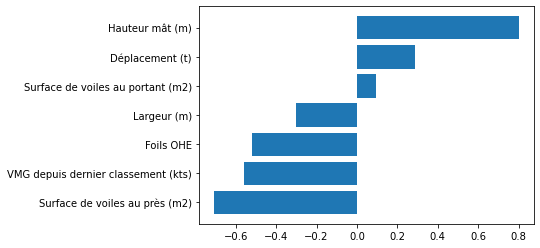

In [59]:
features_names = X.columns
clf_LR = classifiers[0]
clf_LR.fit(X_train, y_train)

for i in range(clf_LR.coef_.shape[0]):
    print('Importance des coefficients de la régression logistique pour la classe {}'.format(i + 1))
    f_importances(clf_LR.coef_[i], features_names)

Importance des coefficients de XGBoost


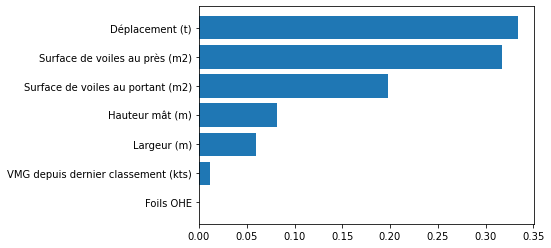

In [60]:
features_names = X.columns
clf_XGB = classifiers[2]
clf_XGB.fit(X_train, y_train)
print('Importance des coefficients de XGBoost')
f_importances(clf_XGB.feature_importances_, features_names)

À partir des matrices de confusion et des courbes ROC, nous observons que les algorithmes SVM avec un noyau non linéaire et XGBoost sont ceux qui parviennent le mieux à prédire la classe du rang des skippers. La classe 3 (rang de 10 à 15) semble la plus difficile à prédire pour l'algorithme XGBoost. Au vu de notre objectif qui serait de prédire le top 10 des skippers, les performances des algorithmes de SVM et XGBoost sont acceptables malgré un écart-type autour de 10% pour les scores de validation croisée. 
<br>De plus, l'expérience et les compétences de navigation du skipper ainsi que d'autres facteurs sont certainement des variables complémentaires permettant d'expliquer le rang de celui-ci. Ces données ne sont pas prises en compte dans notre modèle, ce qui peut expliquer la différence entre notre prédiction et le classement réel.